In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from save_experiment import save_experiment
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [2]:
df = pd.read_csv('../processed_data/hp_energy_production_with_engineered_features_1.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.dropna()

features = [
    'Water_Flow_m3_s', 'avgtempC', 'totalprecipMM', 'humidity', 'pressureMB',
    'Month', 'WaterFlow_Diff_1d', 'WaterFlow_Diff_7d', 'WaterFlow_3day_avg',
    'WaterFlow_7day_avg', 'Temp_Deviation', 'WaterFlow_Humidity',
    'month_sin', 'month_cos', 'Prev_Day_Efficiency', 'Prev_Week_Efficiency'
]
target = 'Normalized_Efficiency'

In [3]:
df_num = df.select_dtypes(include=['number']).dropna()
X = df_num.drop(columns=['Normalized_Efficiency'])
y = df_num['Normalized_Efficiency']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [4]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(n_estimators=500, max_depth=10, learning_rate=0.05, random_state=42, verbosity=0),
    "LightGBM": LGBMRegressor(n_estimators=500, max_depth=10, learning_rate=0.05, random_state=42, verbose=-1),
    "CatBoost": CatBoostRegressor(n_estimators=500, depth=10, learning_rate=0.05, random_state=42, verbose=0),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "Support Vector Regression": SVR(),
    "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=10),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "Multiple Linear Regression (MLR)": LinearRegression(),
    "SVR": SVR()
}

In [5]:
results = {}

for name, model in tqdm(models.items()):
    if name in ['MLP Regressor']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'Prediction': y_pred
    }

/Users/elvinanosrati/Capstone/energy-production-analysis/myenv-py311/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=3.58245e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:19<00:00,  1.36s/it]


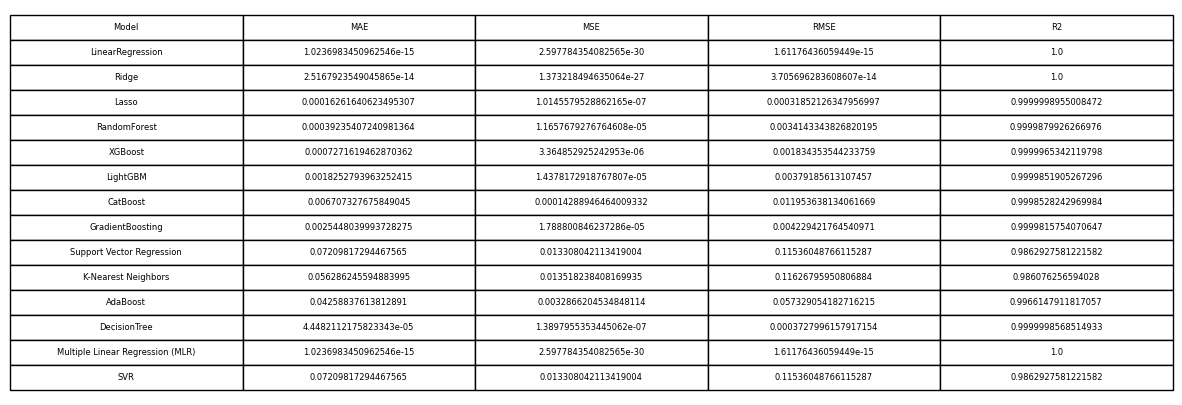

In [6]:
metrics_df = pd.DataFrame({
    'Model': list(results.keys()),
    'MAE': [results[m]['MAE'] for m in results],
    'MSE': [results[m]['MSE'] for m in results],
    'RMSE': [results[m]['RMSE'] for m in results],
    'R2': [results[m]['R2'] for m in results]
})

fig, ax = plt.subplots(figsize=(10,5))
ax.axis('off')
table = ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(6)
table.scale(1.5, 1.5)
plt.show()

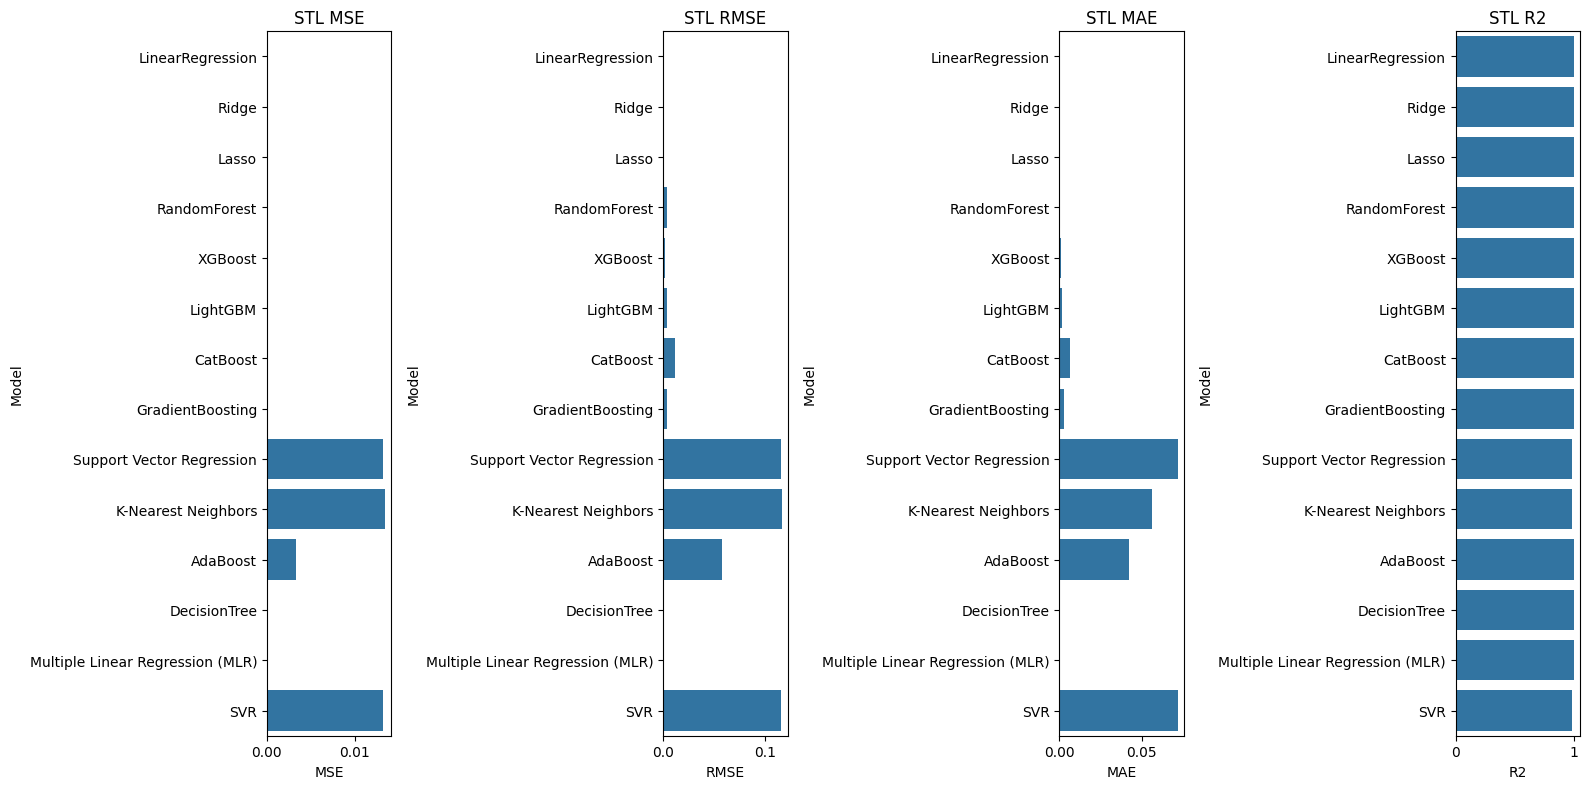

In [7]:
plt.figure(figsize=(16, 8))
for i, metric in enumerate(["MSE", "RMSE", "MAE", "R2"]):
    plt.subplot(1, 4, i + 1)
    sns.barplot(y="Model", x=metric, data=metrics_df)
    plt.title("STL " + metric)
    plt.tight_layout()
plt.show()

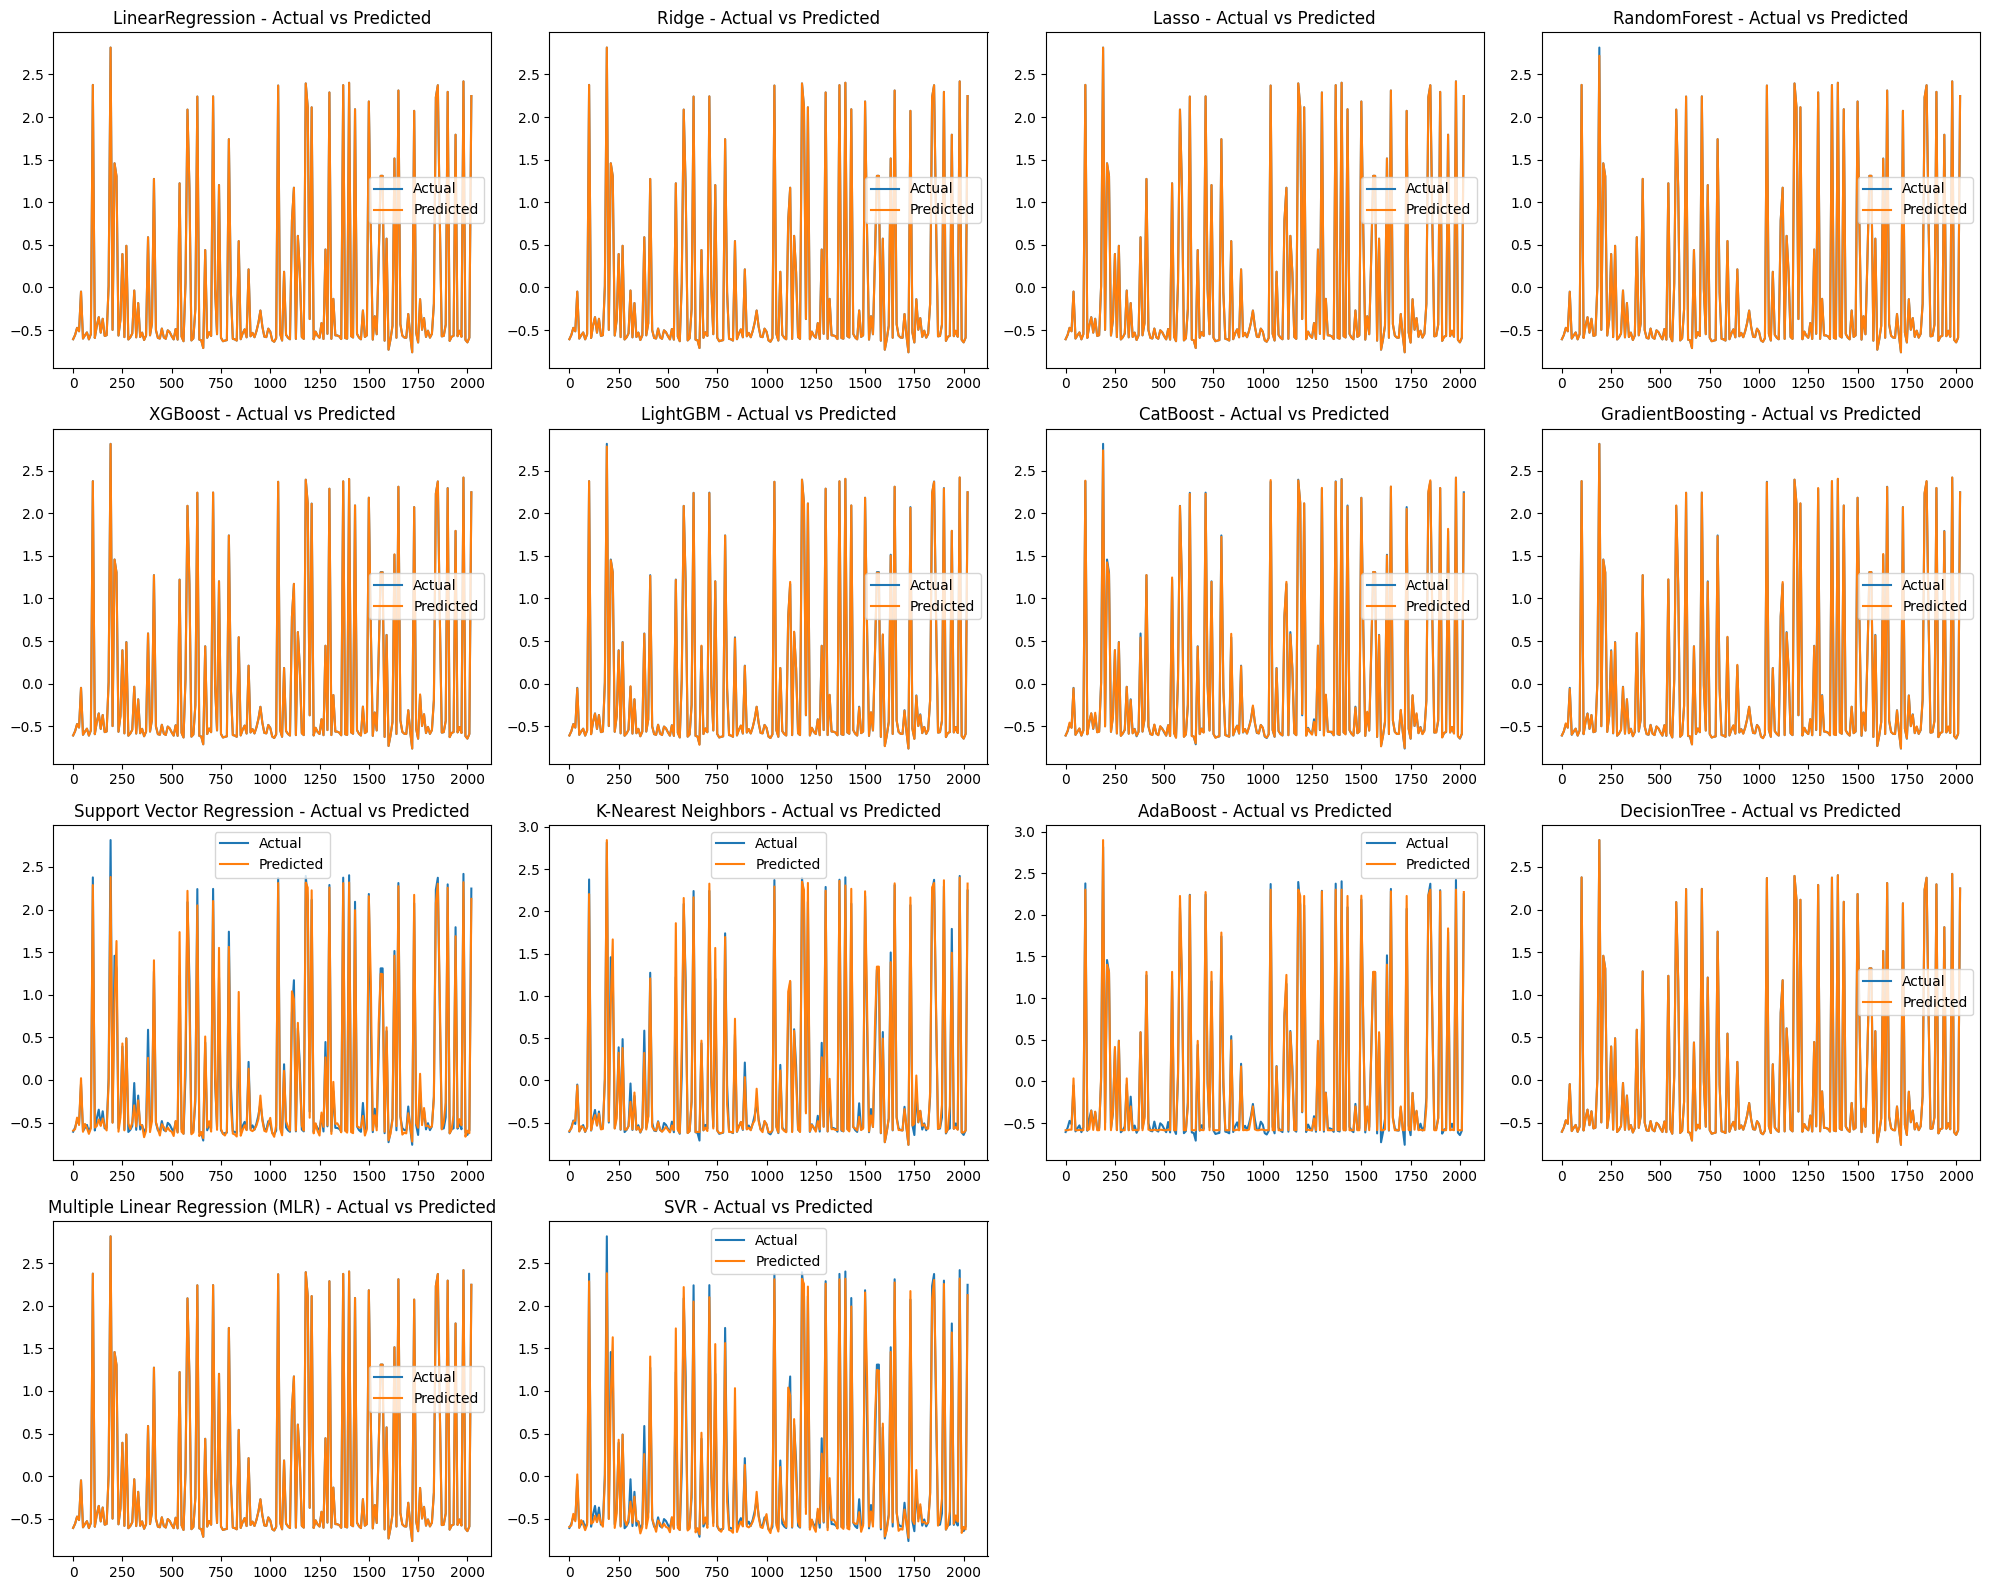

In [8]:
cols_stl      = 4
num_models_stl = len(results)
rows_stl      = int(np.ceil(num_models_stl / cols_stl))

idx = np.arange(len(y_test))[::10]

plt.figure(figsize=(20, 16))
for i, (name, res) in enumerate(results.items()):
    ax = plt.subplot(rows_stl, cols_stl, i + 1)
    ax.plot(idx, y_test.values[idx],        label='Actual')
    ax.plot(idx, res['Prediction'][idx],    label='Predicted')
    ax.set_title(f"{name} - Actual vs Predicted")
    ax.legend()
plt.tight_layout()
plt.show()

In [9]:
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

X_train_tensor           = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor            = torch.tensor(X_test_scaled,  dtype=torch.float32)
X_train_tensor_tabular = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor_tabular  = torch.tensor(X_test_scaled,  dtype=torch.float32)
y_train_tensor           = torch.tensor(y_train.values,    dtype=torch.float32).view(-1, 1)
y_test_tensor            = torch.tensor(y_test.values,     dtype=torch.float32).view(-1, 1)

train_dataset            = TensorDataset(X_train_tensor,        y_train_tensor)
test_dataset             = TensorDataset(X_test_tensor,         y_test_tensor)  

train_dataset_tabular    = TensorDataset(X_train_tensor_tabular, y_train_tensor)
test_dataset_tabular     = TensorDataset(X_test_tensor_tabular,  y_test_tensor)

train_loader             = DataLoader(train_dataset,          batch_size=64,  shuffle=True)
test_loader              = DataLoader(test_dataset,           batch_size=64,  shuffle=False)
train_loader_tabular     = DataLoader(train_dataset_tabular,  batch_size=256, shuffle=True)
test_loader_tabular      = DataLoader(test_dataset_tabular,   batch_size=256, shuffle=False)

In [32]:
def reshape_input(model, xb):
    rnn_models = (LSTMNet, BiLSTMNet, RNNNet, GRUNet, CNNLSTM, DeepLSTMNet, Seq2SeqLSTM, CNNBiLSTM, GRUCNN)
    cnn_models = (CNN1D, CNNLSTM, CNNBiLSTM, GRUCNN)
    tcn_models = (TCN, TCNLSTM)

    if isinstance(model, tcn_models):
        if xb.dim() == 2:
            xb = xb.unsqueeze(-1)
            xb = xb.transpose(1, 2)
    elif isinstance(model, rnn_models + cnn_models):
        if xb.dim() == 2:
            xb = xb.unsqueeze(1)
    return xb

In [10]:
class Net1(nn.Module):
    def __init__(self, input_dim):
        super(Net1, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)


class Net2(nn.Module):
    def __init__(self, input_dim):
        super(Net2, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)


class Net3(nn.Module):
    def __init__(self, input_dim):
        super(Net3, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

class Net4(nn.Module):
    def __init__(self, input_dim):
        super(Net4, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

In [11]:
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(LSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])


class BiLSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.3):
        super(BiLSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers,
                            dropout=dropout, batch_first=True, bidirectional=True)
        self.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(hidden_dim * 2, 1)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])


class RNNNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(RNNNet, self).__init__()
        self.rnn = nn.RNN(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])


class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(GRUNet, self).__init__()
        self.gru = nn.GRU(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

class CNN1D(nn.Module):
    def __init__(self, input_dim, num_filters, num_layers, kernel_size, dropout):
        super().__init__()
        layers = []
        in_ch = input_dim
        for _ in range(num_layers):
            layers += [
                nn.Conv1d(in_ch, num_filters, kernel_size, padding=kernel_size//2),
                nn.ReLU(),
                nn.Dropout(dropout)
            ]
            in_ch = num_filters
        self.features = nn.Sequential(*layers)
        self.fc = nn.Linear(num_filters, 1)

    def forward(self, x):
        x = x.transpose(1, 2)
        out = self.features(x)
        out = out.mean(dim=2)
        return self.fc(out)


class CNNLSTM(nn.Module):
    def __init__(
        self,
        input_dim: int,
        cnn_filters: list[int] = [64, 64],
        cnn_kernel_size: int = 3,
        lstm_hidden: int = 128,
        lstm_layers: int = 2,
        dropout: float = 0.3
    ):
        super().__init__()
        if isinstance(cnn_filters, int):
            cnn_filters = [cnn_filters]
        convs, in_ch = [], 1
        for out_ch in cnn_filters:
            convs += [
                nn.Conv1d(in_ch, out_ch, kernel_size=cnn_kernel_size,
                          padding=cnn_kernel_size//2),
                nn.ReLU(),
                nn.Dropout(dropout)
            ]
            in_ch = out_ch
        self.cnn = nn.Sequential(*convs)
        self.lstm = nn.LSTM(
            input_size=in_ch,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=dropout if lstm_layers > 1 else 0.0
        )
        self.head = nn.Linear(lstm_hidden, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if x.dim() == 4:
            x = x.squeeze(1)

        if x.dim() == 2:
            b, f = x.shape
            x = x.unsqueeze(1)       
            x = self.cnn(x)          
            x = x.transpose(1, 2)     
            out, _ = self.lstm(x)     
            return self.head(out[:, -1, :])

        elif x.dim() == 3:
            b, s, f = x.shape
            x = x.reshape(b * s, f).unsqueeze(1)  
            x = self.cnn(x)                      
            x = x.mean(dim=2)                     
            x = x.view(b, s, -1)                  
            out, _ = self.lstm(x)                 
            return self.head(out[:, -1, :])

        else:
            raise ValueError(f"Unsupported input dims: {x.dim()}")


class FNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

class DeepFNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

class DeepLSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=4, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_dim,
                            hidden_size=hidden_dim,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding, dropout):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)

        self.downsample = (nn.Conv1d(in_channels, out_channels, 1)
                           if in_channels != out_channels else None)
        self.relu = nn.ReLU()

    def forward(self, x):
        L = x.size(2) 
        out = self.conv1(x)[..., :L]    
        out = self.bn1(out); out = self.relu(out); out = self.dropout1(out)

        out = self.conv2(out)[..., :L]
        out = self.bn2(out); out = self.relu(out); out = self.dropout2(out)

        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride, dilation, dropout):
        super().__init__()
        padding = (kernel_size - 1) * dilation // 2

        self.conv1 = nn.Conv1d(
            in_channels, out_channels, kernel_size,
            stride=stride, padding=padding, dilation=dilation
        )
        self.bn1      = nn.BatchNorm1d(out_channels)
        self.relu1    = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(
            out_channels, out_channels, kernel_size,
            stride=stride, padding=padding, dilation=dilation
        )
        self.bn2      = nn.BatchNorm1d(out_channels)
        self.relu2    = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.downsample = (
            nn.Conv1d(in_channels, out_channels, 1)
            if in_channels != out_channels else None
        )
        self.final_relu = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.dropout1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.dropout2(out)

        res = x if self.downsample is None else self.downsample(x)
        return self.final_relu(out + res)


class TCN(nn.Module):
    def __init__(self, input_dim, num_channels, kernel_size=3, dropout=0.2):
        super().__init__()
        layers = []
        for i, out_ch in enumerate(num_channels):
            in_ch   = input_dim if i == 0 else num_channels[i-1]
            dilation = 2 ** i
            layers.append(
                TemporalBlock(
                    in_channels=in_ch,
                    out_channels=out_ch,
                    kernel_size=kernel_size,
                    stride=1,
                    dilation=dilation,
                    dropout=dropout
                )
            )
        self.network = nn.Sequential(*layers)
        self.fc      = nn.Linear(num_channels[-1], 1)

    def forward(self, x):
        x = x.transpose(1, 2)     
        y = self.network(x)       
        y = y[:, :, -1]           
        return self.fc(y)    

class CNNBiLSTM(nn.Module):
    def __init__(self, input_dim, cnn_filters=32, lstm_hidden=64, lstm_layers=2, dropout=0.3):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(input_dim, cnn_filters, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.bilstm = nn.LSTM(
            input_size=cnn_filters,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout
        )
        self.fc = nn.Linear(2 * lstm_hidden, 1)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.cnn(x)
        x = x.transpose(1, 2)
        out, _ = self.bilstm(x)
        return self.fc(out[:, -1, :])

class GRUCNN(nn.Module):
    def __init__(self, input_dim, gru_hidden=64, cnn_filters=32, kernel_size=3, dropout=0.3):
        super().__init__()
        self.gru = nn.GRU(input_dim, gru_hidden, batch_first=True)
        self.cnn = nn.Sequential(
            nn.Conv1d(gru_hidden, cnn_filters, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.fc = nn.Linear(cnn_filters, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.cnn(out.transpose(1, 2))
        out = out.mean(dim=2)
        return self.fc(out)

class TCNLSTM(nn.Module):
    def __init__(self, input_dim, tcn_channels=[64,64], lstm_hidden=64, lstm_layers=1, kernel_size=3, dropout=0.3):
        super().__init__()
        self.tcn = TCN(input_dim, tcn_channels, kernel_size=kernel_size, dropout=dropout)
        self.lstm = nn.LSTM(input_size=tcn_channels[-1], hidden_size=lstm_hidden, num_layers=lstm_layers, batch_first=True)
        self.fc = nn.Linear(lstm_hidden, 1)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.tcn.network(x).transpose(1, 2)
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class Seq2SeqLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.3):
        super(Seq2SeqLSTM, self).__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.decoder = nn.LSTM(hidden_dim, hidden_dim, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        _, (hidden, cell) = self.encoder(x)
        dec_input = torch.zeros(x.size(0), 1, hidden.size(2)).to(x.device)
        out, _ = self.decoder(dec_input, (hidden, cell))
        return self.fc(out[:, -1, :])
  

In [12]:
def train_model(name, model, train_loader, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor,epochs=1000, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    history = []
    for epoch in tqdm(range(1, epochs + 1)):
        model.train()
        running_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        if epoch % 10 == 0:
            model.eval()
            with torch.no_grad():
                y_train_pred = model(X_train_tensor)
                y_test_pred  = model(X_test_tensor)
                
                train_mse  = mean_squared_error(y_train_tensor.numpy(), y_train_pred.numpy())
                test_mse   = mean_squared_error(y_test_tensor.numpy(), y_test_pred.numpy())
                train_rmse = np.sqrt(train_mse)
                test_rmse  = np.sqrt(test_mse)
                train_mae  = mean_absolute_error(y_train_tensor.numpy(), y_train_pred.numpy())
                test_mae   = mean_absolute_error(y_test_tensor.numpy(), y_test_pred.numpy())
                train_r2   = r2_score(y_train_tensor.numpy(), y_train_pred.numpy())
                test_r2    = r2_score(y_test_tensor.numpy(), y_test_pred.numpy())
                
                print(f"\nModel: {name} | Epoch: {epoch}")
                print(f"Train: MSE: {train_mse:.4f}, RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R2: {train_r2:.4f}")
                print(f"Test:  MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R2: {test_r2:.4f}")
                
                history.append({
                    "Model": name,
                    "Epoch": epoch,
                    "Train MSE": train_mse,
                    "Test MSE": test_mse,
                    "Train RMSE": train_rmse,
                    "Test RMSE": test_rmse,
                    "Train MAE": train_mae,
                    "Test MAE": test_mae,
                    "Train R2": train_r2,
                    "Test R2": test_r2
                })
    return history

In [13]:
def train_ts_model(name, model, train_loader, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, epochs=200, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

    history = []
    for epoch in tqdm(range(1, epochs + 1), desc=f"Training {name}"):
        model.train()
        running_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()    
            running_loss += loss.item()

        if epoch % 10 == 0:
            model.eval()
            with torch.no_grad():
                y_train_pred = model(X_train_tensor)
                y_test_pred  = model(X_test_tensor)

                train_mse = mean_squared_error(y_train_tensor.numpy(), y_train_pred.numpy())
                test_mse  = mean_squared_error(y_test_tensor.numpy(), y_test_pred.numpy())
                train_rmse = np.sqrt(train_mse)
                test_rmse  = np.sqrt(test_mse)
                train_mae = mean_absolute_error(y_train_tensor.numpy(), y_train_pred.numpy())
                test_mae  = mean_absolute_error(y_test_tensor.numpy(), y_test_pred.numpy())
                train_r2  = r2_score(y_train_tensor.numpy(), y_train_pred.numpy())
                test_r2   = r2_score(y_test_tensor.numpy(), y_test_pred.numpy())

                history.append({
                    "Model": name,
                    "Epoch": epoch,
                    "Train MSE": train_mse,
                    "Test MSE": test_mse,
                    "Train RMSE": train_rmse,
                    "Test RMSE": test_rmse,
                    "Train MAE": train_mae,
                    "Test MAE": test_mae,
                    "Train R2": train_r2,
                    "Test R2": test_r2
                })
        
        if epoch % 100 == 0:
            print(f"\nModel: {name} | Epoch: {epoch}")
            print(f"Train: MSE: {train_mse:.4f}, RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R2: {train_r2:.4f}")
            print(f"Test:  MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R2: {test_r2:.4f}")

    return history


In [14]:
nets = {
    "Net1":   Net1(X.shape[1]),
    "Net2":   Net2(X.shape[1]),
    "Net3":   Net3(X.shape[1]),
    "Net4":   Net4(X.shape[1])
}

nets_tabular = {
    "Net1":    Net1(X.shape[1]),
    "Net2":    Net2(X.shape[1]),
    "Net3":    Net3(X.shape[1]),
    "Net4":    Net4(X.shape[1]),
    "FNN":     FNN(X.shape[1]),
    "DeepFNN": DeepFNN(X.shape[1])
}

In [15]:
results = []
for name, net in nets.items():
    results += train_model(name, net, train_loader, 
                               X_train_tensor, y_train_tensor, 
                               X_test_tensor, y_test_tensor,
                               epochs=100, lr=1e-3)
    
nn_metrics_df = pd.DataFrame(results)

 11%|███████████▏                                                                                          | 11/100 [00:01<00:08, 10.90it/s]


Model: Net1 | Epoch: 10
Train: MSE: 0.0004, RMSE: 0.0205, MAE: 0.0146, R2: 0.9996
Test:  MSE: 0.0005, RMSE: 0.0217, MAE: 0.0150, R2: 0.9995


 21%|█████████████████████▍                                                                                | 21/100 [00:02<00:06, 11.68it/s]


Model: Net1 | Epoch: 20
Train: MSE: 0.0002, RMSE: 0.0136, MAE: 0.0097, R2: 0.9998
Test:  MSE: 0.0002, RMSE: 0.0156, MAE: 0.0106, R2: 0.9997


 31%|███████████████████████████████▌                                                                      | 31/100 [00:02<00:05, 11.90it/s]


Model: Net1 | Epoch: 30
Train: MSE: 0.0001, RMSE: 0.0101, MAE: 0.0074, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0120, MAE: 0.0081, R2: 0.9999


 41%|█████████████████████████████████████████▊                                                            | 41/100 [00:03<00:04, 11.94it/s]


Model: Net1 | Epoch: 40
Train: MSE: 0.0001, RMSE: 0.0085, MAE: 0.0063, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0107, MAE: 0.0071, R2: 0.9999


 51%|████████████████████████████████████████████████████                                                  | 51/100 [00:04<00:04, 11.90it/s]


Model: Net1 | Epoch: 50
Train: MSE: 0.0001, RMSE: 0.0079, MAE: 0.0063, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0094, MAE: 0.0069, R2: 0.9999


 61%|██████████████████████████████████████████████████████████████▏                                       | 61/100 [00:05<00:03, 11.98it/s]


Model: Net1 | Epoch: 60
Train: MSE: 0.0000, RMSE: 0.0061, MAE: 0.0045, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0076, MAE: 0.0051, R2: 0.9999


 71%|████████████████████████████████████████████████████████████████████████▍                             | 71/100 [00:06<00:02, 11.89it/s]


Model: Net1 | Epoch: 70
Train: MSE: 0.0000, RMSE: 0.0059, MAE: 0.0046, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0072, MAE: 0.0052, R2: 0.9999


 81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 81/100 [00:07<00:01, 11.75it/s]


Model: Net1 | Epoch: 80
Train: MSE: 0.0000, RMSE: 0.0057, MAE: 0.0045, R2: 1.0000
Test:  MSE: 0.0000, RMSE: 0.0070, MAE: 0.0049, R2: 0.9999


 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 91/100 [00:07<00:00, 12.00it/s]


Model: Net1 | Epoch: 90
Train: MSE: 0.0000, RMSE: 0.0046, MAE: 0.0035, R2: 1.0000
Test:  MSE: 0.0000, RMSE: 0.0059, MAE: 0.0040, R2: 1.0000


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.51it/s]



Model: Net1 | Epoch: 100
Train: MSE: 0.0000, RMSE: 0.0067, MAE: 0.0052, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0076, MAE: 0.0056, R2: 0.9999


 11%|███████████▏                                                                                          | 11/100 [00:01<00:11,  7.43it/s]


Model: Net2 | Epoch: 10
Train: MSE: 0.0001, RMSE: 0.0098, MAE: 0.0071, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0118, MAE: 0.0080, R2: 0.9999


 21%|█████████████████████▍                                                                                | 21/100 [00:02<00:10,  7.38it/s]


Model: Net2 | Epoch: 20
Train: MSE: 0.0001, RMSE: 0.0072, MAE: 0.0054, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0086, MAE: 0.0059, R2: 0.9999


 31%|███████████████████████████████▌                                                                      | 31/100 [00:04<00:09,  7.27it/s]


Model: Net2 | Epoch: 30
Train: MSE: 0.0001, RMSE: 0.0088, MAE: 0.0069, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0094, MAE: 0.0072, R2: 0.9999


 41%|█████████████████████████████████████████▊                                                            | 41/100 [00:05<00:08,  7.25it/s]


Model: Net2 | Epoch: 40
Train: MSE: 0.0000, RMSE: 0.0062, MAE: 0.0044, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0077, MAE: 0.0051, R2: 0.9999


 51%|████████████████████████████████████████████████████                                                  | 51/100 [00:06<00:06,  7.29it/s]


Model: Net2 | Epoch: 50
Train: MSE: 0.0003, RMSE: 0.0178, MAE: 0.0150, R2: 0.9997
Test:  MSE: 0.0003, RMSE: 0.0179, MAE: 0.0149, R2: 0.9997


 61%|██████████████████████████████████████████████████████████████▏                                       | 61/100 [00:08<00:05,  7.25it/s]


Model: Net2 | Epoch: 60
Train: MSE: 0.0001, RMSE: 0.0086, MAE: 0.0064, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0092, MAE: 0.0067, R2: 0.9999


 71%|████████████████████████████████████████████████████████████████████████▍                             | 71/100 [00:09<00:03,  7.41it/s]


Model: Net2 | Epoch: 70
Train: MSE: 0.0000, RMSE: 0.0055, MAE: 0.0041, R2: 1.0000
Test:  MSE: 0.0000, RMSE: 0.0065, MAE: 0.0045, R2: 1.0000


 81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 81/100 [00:11<00:02,  7.42it/s]


Model: Net2 | Epoch: 80
Train: MSE: 0.0001, RMSE: 0.0081, MAE: 0.0065, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0087, MAE: 0.0068, R2: 0.9999


 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 91/100 [00:12<00:01,  7.42it/s]


Model: Net2 | Epoch: 90
Train: MSE: 0.0000, RMSE: 0.0038, MAE: 0.0027, R2: 1.0000
Test:  MSE: 0.0000, RMSE: 0.0049, MAE: 0.0031, R2: 1.0000


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.34it/s]



Model: Net2 | Epoch: 100
Train: MSE: 0.0001, RMSE: 0.0116, MAE: 0.0101, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0118, MAE: 0.0102, R2: 0.9999


 11%|███████████▏                                                                                          | 11/100 [00:02<00:16,  5.40it/s]


Model: Net3 | Epoch: 10
Train: MSE: 0.0001, RMSE: 0.0105, MAE: 0.0081, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0122, MAE: 0.0088, R2: 0.9998


 21%|█████████████████████▍                                                                                | 21/100 [00:03<00:15,  5.04it/s]


Model: Net3 | Epoch: 20
Train: MSE: 0.0001, RMSE: 0.0122, MAE: 0.0096, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0137, MAE: 0.0102, R2: 0.9998


 31%|███████████████████████████████▌                                                                      | 31/100 [00:06<00:13,  5.06it/s]


Model: Net3 | Epoch: 30
Train: MSE: 0.0001, RMSE: 0.0077, MAE: 0.0059, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0090, MAE: 0.0064, R2: 0.9999


 41%|█████████████████████████████████████████▊                                                            | 41/100 [00:07<00:10,  5.60it/s]


Model: Net3 | Epoch: 40
Train: MSE: 0.0000, RMSE: 0.0048, MAE: 0.0034, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0072, MAE: 0.0042, R2: 0.9999


 51%|████████████████████████████████████████████████████                                                  | 51/100 [00:09<00:08,  5.67it/s]


Model: Net3 | Epoch: 50
Train: MSE: 0.0001, RMSE: 0.0096, MAE: 0.0076, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0110, MAE: 0.0081, R2: 0.9999


 61%|██████████████████████████████████████████████████████████████▏                                       | 61/100 [00:11<00:06,  5.76it/s]


Model: Net3 | Epoch: 60
Train: MSE: 0.0000, RMSE: 0.0064, MAE: 0.0044, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0072, MAE: 0.0049, R2: 0.9999


 71%|████████████████████████████████████████████████████████████████████████▍                             | 71/100 [00:13<00:05,  5.68it/s]


Model: Net3 | Epoch: 70
Train: MSE: 0.0001, RMSE: 0.0103, MAE: 0.0094, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0106, MAE: 0.0095, R2: 0.9999


 81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 81/100 [00:14<00:03,  5.73it/s]


Model: Net3 | Epoch: 80
Train: MSE: 0.0000, RMSE: 0.0046, MAE: 0.0033, R2: 1.0000
Test:  MSE: 0.0000, RMSE: 0.0056, MAE: 0.0037, R2: 1.0000


 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 91/100 [00:16<00:01,  5.70it/s]


Model: Net3 | Epoch: 90
Train: MSE: 0.0000, RMSE: 0.0039, MAE: 0.0029, R2: 1.0000
Test:  MSE: 0.0000, RMSE: 0.0049, MAE: 0.0034, R2: 1.0000


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.51it/s]



Model: Net3 | Epoch: 100
Train: MSE: 0.0002, RMSE: 0.0135, MAE: 0.0075, R2: 0.9998
Test:  MSE: 0.0002, RMSE: 0.0132, MAE: 0.0074, R2: 0.9998


 10%|██████████▏                                                                                           | 10/100 [00:04<00:37,  2.42it/s]


Model: Net4 | Epoch: 10
Train: MSE: 0.0062, RMSE: 0.0788, MAE: 0.0531, R2: 0.9938
Test:  MSE: 0.0065, RMSE: 0.0808, MAE: 0.0542, R2: 0.9933


 20%|████████████████████▍                                                                                 | 20/100 [00:08<00:32,  2.49it/s]


Model: Net4 | Epoch: 20
Train: MSE: 0.0142, RMSE: 0.1193, MAE: 0.0741, R2: 0.9859
Test:  MSE: 0.0142, RMSE: 0.1190, MAE: 0.0743, R2: 0.9854


 30%|██████████████████████████████▌                                                                       | 30/100 [00:12<00:28,  2.49it/s]


Model: Net4 | Epoch: 30
Train: MSE: 0.0081, RMSE: 0.0901, MAE: 0.0524, R2: 0.9919
Test:  MSE: 0.0081, RMSE: 0.0901, MAE: 0.0523, R2: 0.9916


 40%|████████████████████████████████████████▊                                                             | 40/100 [00:16<00:24,  2.44it/s]


Model: Net4 | Epoch: 40
Train: MSE: 0.0148, RMSE: 0.1216, MAE: 0.0733, R2: 0.9853
Test:  MSE: 0.0146, RMSE: 0.1208, MAE: 0.0727, R2: 0.9850


 50%|███████████████████████████████████████████████████                                                   | 50/100 [00:20<00:20,  2.41it/s]


Model: Net4 | Epoch: 50
Train: MSE: 0.0162, RMSE: 0.1274, MAE: 0.0762, R2: 0.9839
Test:  MSE: 0.0157, RMSE: 0.1253, MAE: 0.0752, R2: 0.9838


 60%|█████████████████████████████████████████████████████████████▏                                        | 60/100 [00:24<00:17,  2.32it/s]


Model: Net4 | Epoch: 60
Train: MSE: 0.0219, RMSE: 0.1480, MAE: 0.0816, R2: 0.9783
Test:  MSE: 0.0213, RMSE: 0.1458, MAE: 0.0804, R2: 0.9781


 70%|███████████████████████████████████████████████████████████████████████▍                              | 70/100 [00:28<00:12,  2.45it/s]


Model: Net4 | Epoch: 70
Train: MSE: 0.0071, RMSE: 0.0845, MAE: 0.0630, R2: 0.9929
Test:  MSE: 0.0068, RMSE: 0.0825, MAE: 0.0614, R2: 0.9930


 80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 80/100 [00:32<00:08,  2.46it/s]


Model: Net4 | Epoch: 80
Train: MSE: 0.0149, RMSE: 0.1220, MAE: 0.0617, R2: 0.9852
Test:  MSE: 0.0142, RMSE: 0.1191, MAE: 0.0607, R2: 0.9854


 90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 90/100 [00:36<00:04,  2.35it/s]


Model: Net4 | Epoch: 90
Train: MSE: 0.0206, RMSE: 0.1436, MAE: 0.0751, R2: 0.9795
Test:  MSE: 0.0196, RMSE: 0.1399, MAE: 0.0731, R2: 0.9798


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:40<00:00,  2.46it/s]


Model: Net4 | Epoch: 100
Train: MSE: 0.0198, RMSE: 0.1406, MAE: 0.0703, R2: 0.9804
Test:  MSE: 0.0189, RMSE: 0.1375, MAE: 0.0683, R2: 0.9805


In [16]:
results_tabular = []
for name, net in nets_tabular.items():
    results_tabular += train_model(
        name, net, train_loader_tabular,
        X_train_tensor_tabular, y_train_tensor,
        X_test_tensor_tabular,  y_test_tensor,
        epochs=100, lr=1e-3
    )
nn_metrics_df_tabular = pd.DataFrame(results_tabular)

 12%|████████████▏                                                                                         | 12/100 [00:00<00:04, 17.94it/s]


Model: Net1 | Epoch: 10
Train: MSE: 0.0012, RMSE: 0.0352, MAE: 0.0255, R2: 0.9988
Test:  MSE: 0.0013, RMSE: 0.0363, MAE: 0.0268, R2: 0.9986


 22%|██████████████████████▍                                                                               | 22/100 [00:01<00:04, 18.05it/s]


Model: Net1 | Epoch: 20
Train: MSE: 0.0005, RMSE: 0.0218, MAE: 0.0156, R2: 0.9995
Test:  MSE: 0.0005, RMSE: 0.0229, MAE: 0.0164, R2: 0.9995


 32%|████████████████████████████████▋                                                                     | 32/100 [00:02<00:05, 11.99it/s]


Model: Net1 | Epoch: 30
Train: MSE: 0.0003, RMSE: 0.0174, MAE: 0.0124, R2: 0.9997
Test:  MSE: 0.0003, RMSE: 0.0185, MAE: 0.0132, R2: 0.9996


 42%|██████████████████████████████████████████▊                                                           | 42/100 [00:02<00:03, 16.77it/s]


Model: Net1 | Epoch: 40
Train: MSE: 0.0002, RMSE: 0.0150, MAE: 0.0107, R2: 0.9998
Test:  MSE: 0.0003, RMSE: 0.0164, MAE: 0.0114, R2: 0.9997


 52%|█████████████████████████████████████████████████████                                                 | 52/100 [00:03<00:02, 18.29it/s]


Model: Net1 | Epoch: 50
Train: MSE: 0.0002, RMSE: 0.0137, MAE: 0.0097, R2: 0.9998
Test:  MSE: 0.0002, RMSE: 0.0151, MAE: 0.0105, R2: 0.9998


 60%|█████████████████████████████████████████████████████████████▏                                        | 60/100 [00:03<00:02, 18.12it/s]


Model: Net1 | Epoch: 60
Train: MSE: 0.0002, RMSE: 0.0126, MAE: 0.0089, R2: 0.9998
Test:  MSE: 0.0002, RMSE: 0.0140, MAE: 0.0096, R2: 0.9998


 72%|█████████████████████████████████████████████████████████████████████████▍                            | 72/100 [00:04<00:01, 17.13it/s]


Model: Net1 | Epoch: 70
Train: MSE: 0.0001, RMSE: 0.0120, MAE: 0.0086, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0135, MAE: 0.0094, R2: 0.9998


 82%|███████████████████████████████████████████████████████████████████████████████████▋                  | 82/100 [00:05<00:00, 18.42it/s]


Model: Net1 | Epoch: 80
Train: MSE: 0.0001, RMSE: 0.0111, MAE: 0.0079, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0127, MAE: 0.0087, R2: 0.9998


 92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 92/100 [00:05<00:00, 18.74it/s]


Model: Net1 | Epoch: 90
Train: MSE: 0.0001, RMSE: 0.0104, MAE: 0.0073, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0120, MAE: 0.0082, R2: 0.9999


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.08it/s]



Model: Net1 | Epoch: 100
Train: MSE: 0.0001, RMSE: 0.0099, MAE: 0.0068, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0115, MAE: 0.0077, R2: 0.9999


 12%|████████████▏                                                                                         | 12/100 [00:00<00:05, 15.11it/s]


Model: Net2 | Epoch: 10
Train: MSE: 0.0004, RMSE: 0.0200, MAE: 0.0145, R2: 0.9996
Test:  MSE: 0.0005, RMSE: 0.0218, MAE: 0.0156, R2: 0.9995


 20%|████████████████████▍                                                                                 | 20/100 [00:01<00:06, 11.79it/s]


Model: Net2 | Epoch: 20
Train: MSE: 0.0002, RMSE: 0.0133, MAE: 0.0095, R2: 0.9998
Test:  MSE: 0.0002, RMSE: 0.0152, MAE: 0.0104, R2: 0.9998


 32%|████████████████████████████████▋                                                                     | 32/100 [00:02<00:06, 11.03it/s]


Model: Net2 | Epoch: 30
Train: MSE: 0.0001, RMSE: 0.0102, MAE: 0.0074, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0124, MAE: 0.0083, R2: 0.9998


 42%|██████████████████████████████████████████▊                                                           | 42/100 [00:03<00:04, 11.87it/s]


Model: Net2 | Epoch: 40
Train: MSE: 0.0001, RMSE: 0.0084, MAE: 0.0060, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0106, MAE: 0.0069, R2: 0.9999


 52%|█████████████████████████████████████████████████████                                                 | 52/100 [00:04<00:03, 12.02it/s]


Model: Net2 | Epoch: 50
Train: MSE: 0.0001, RMSE: 0.0078, MAE: 0.0057, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0099, MAE: 0.0068, R2: 0.9999


 62%|███████████████████████████████████████████████████████████████▏                                      | 62/100 [00:05<00:03, 11.47it/s]


Model: Net2 | Epoch: 60
Train: MSE: 0.0000, RMSE: 0.0066, MAE: 0.0048, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0087, MAE: 0.0057, R2: 0.9999


 72%|█████████████████████████████████████████████████████████████████████████▍                            | 72/100 [00:06<00:02, 12.00it/s]


Model: Net2 | Epoch: 70
Train: MSE: 0.0001, RMSE: 0.0071, MAE: 0.0052, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0090, MAE: 0.0059, R2: 0.9999


 82%|███████████████████████████████████████████████████████████████████████████████████▋                  | 82/100 [00:06<00:01, 12.42it/s]


Model: Net2 | Epoch: 80
Train: MSE: 0.0000, RMSE: 0.0057, MAE: 0.0044, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0079, MAE: 0.0055, R2: 0.9999


 92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 92/100 [00:07<00:00, 11.41it/s]


Model: Net2 | Epoch: 90
Train: MSE: 0.0000, RMSE: 0.0049, MAE: 0.0036, R2: 1.0000
Test:  MSE: 0.0000, RMSE: 0.0071, MAE: 0.0046, R2: 0.9999


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.78it/s]



Model: Net2 | Epoch: 100
Train: MSE: 0.0001, RMSE: 0.0075, MAE: 0.0063, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0092, MAE: 0.0070, R2: 0.9999


 11%|███████████▏                                                                                          | 11/100 [00:01<00:10,  8.48it/s]


Model: Net3 | Epoch: 10
Train: MSE: 0.0003, RMSE: 0.0158, MAE: 0.0115, R2: 0.9998
Test:  MSE: 0.0003, RMSE: 0.0181, MAE: 0.0121, R2: 0.9997


 21%|█████████████████████▍                                                                                | 21/100 [00:02<00:09,  8.47it/s]


Model: Net3 | Epoch: 20
Train: MSE: 0.0001, RMSE: 0.0107, MAE: 0.0084, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0129, MAE: 0.0091, R2: 0.9998


 31%|███████████████████████████████▌                                                                      | 31/100 [00:03<00:08,  8.38it/s]


Model: Net3 | Epoch: 30
Train: MSE: 0.0001, RMSE: 0.0071, MAE: 0.0052, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0098, MAE: 0.0062, R2: 0.9999


 41%|█████████████████████████████████████████▊                                                            | 41/100 [00:04<00:06,  8.52it/s]


Model: Net3 | Epoch: 40
Train: MSE: 0.0001, RMSE: 0.0104, MAE: 0.0081, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0121, MAE: 0.0085, R2: 0.9999


 51%|████████████████████████████████████████████████████                                                  | 51/100 [00:05<00:05,  9.06it/s]


Model: Net3 | Epoch: 50
Train: MSE: 0.0000, RMSE: 0.0059, MAE: 0.0043, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0084, MAE: 0.0052, R2: 0.9999


 61%|██████████████████████████████████████████████████████████████▏                                       | 61/100 [00:06<00:03,  9.98it/s]


Model: Net3 | Epoch: 60
Train: MSE: 0.0000, RMSE: 0.0064, MAE: 0.0052, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0084, MAE: 0.0060, R2: 0.9999


 71%|████████████████████████████████████████████████████████████████████████▍                             | 71/100 [00:07<00:02, 10.03it/s]


Model: Net3 | Epoch: 70
Train: MSE: 0.0000, RMSE: 0.0042, MAE: 0.0030, R2: 1.0000
Test:  MSE: 0.0000, RMSE: 0.0068, MAE: 0.0040, R2: 1.0000


 81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 81/100 [00:08<00:01,  9.70it/s]


Model: Net3 | Epoch: 80
Train: MSE: 0.0002, RMSE: 0.0147, MAE: 0.0119, R2: 0.9998
Test:  MSE: 0.0002, RMSE: 0.0156, MAE: 0.0122, R2: 0.9998


 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 91/100 [00:10<00:00,  9.04it/s]


Model: Net3 | Epoch: 90
Train: MSE: 0.0000, RMSE: 0.0050, MAE: 0.0040, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0071, MAE: 0.0049, R2: 0.9999


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.78it/s]



Model: Net3 | Epoch: 100
Train: MSE: 0.0000, RMSE: 0.0055, MAE: 0.0043, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0075, MAE: 0.0050, R2: 0.9999


 10%|██████████▏                                                                                           | 10/100 [00:02<00:20,  4.40it/s]


Model: Net4 | Epoch: 10
Train: MSE: 0.0055, RMSE: 0.0741, MAE: 0.0483, R2: 0.9946
Test:  MSE: 0.0054, RMSE: 0.0734, MAE: 0.0479, R2: 0.9944


 20%|████████████████████▍                                                                                 | 20/100 [00:04<00:17,  4.50it/s]


Model: Net4 | Epoch: 20
Train: MSE: 0.0089, RMSE: 0.0943, MAE: 0.0575, R2: 0.9912
Test:  MSE: 0.0087, RMSE: 0.0935, MAE: 0.0577, R2: 0.9910


 30%|██████████████████████████████▌                                                                       | 30/100 [00:06<00:16,  4.14it/s]


Model: Net4 | Epoch: 30
Train: MSE: 0.0057, RMSE: 0.0755, MAE: 0.0491, R2: 0.9943
Test:  MSE: 0.0059, RMSE: 0.0768, MAE: 0.0497, R2: 0.9939


 40%|████████████████████████████████████████▊                                                             | 40/100 [00:09<00:13,  4.36it/s]


Model: Net4 | Epoch: 40
Train: MSE: 0.0047, RMSE: 0.0687, MAE: 0.0460, R2: 0.9953
Test:  MSE: 0.0050, RMSE: 0.0706, MAE: 0.0466, R2: 0.9949


 50%|███████████████████████████████████████████████████                                                   | 50/100 [00:11<00:10,  4.55it/s]


Model: Net4 | Epoch: 50
Train: MSE: 0.0071, RMSE: 0.0841, MAE: 0.0607, R2: 0.9930
Test:  MSE: 0.0071, RMSE: 0.0844, MAE: 0.0607, R2: 0.9927


 60%|█████████████████████████████████████████████████████████████▏                                        | 60/100 [00:13<00:08,  4.55it/s]


Model: Net4 | Epoch: 60
Train: MSE: 0.0141, RMSE: 0.1187, MAE: 0.0872, R2: 0.9860
Test:  MSE: 0.0140, RMSE: 0.1182, MAE: 0.0865, R2: 0.9856


 70%|███████████████████████████████████████████████████████████████████████▍                              | 70/100 [00:15<00:06,  4.39it/s]


Model: Net4 | Epoch: 70
Train: MSE: 0.0160, RMSE: 0.1265, MAE: 0.0884, R2: 0.9841
Test:  MSE: 0.0161, RMSE: 0.1269, MAE: 0.0883, R2: 0.9834


 80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 80/100 [00:17<00:04,  4.48it/s]


Model: Net4 | Epoch: 80
Train: MSE: 0.0101, RMSE: 0.1005, MAE: 0.0705, R2: 0.9900
Test:  MSE: 0.0099, RMSE: 0.0996, MAE: 0.0697, R2: 0.9898


 90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 90/100 [00:19<00:02,  4.43it/s]


Model: Net4 | Epoch: 90
Train: MSE: 0.0190, RMSE: 0.1377, MAE: 0.0928, R2: 0.9812
Test:  MSE: 0.0183, RMSE: 0.1354, MAE: 0.0914, R2: 0.9811


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.52it/s]



Model: Net4 | Epoch: 100
Train: MSE: 0.0224, RMSE: 0.1498, MAE: 0.0768, R2: 0.9777
Test:  MSE: 0.0218, RMSE: 0.1476, MAE: 0.0761, R2: 0.9775


 12%|████████████▏                                                                                         | 12/100 [00:01<00:08, 10.76it/s]


Model: FNN | Epoch: 10
Train: MSE: 0.0069, RMSE: 0.0831, MAE: 0.0619, R2: 0.9931
Test:  MSE: 0.0075, RMSE: 0.0868, MAE: 0.0642, R2: 0.9922


 22%|██████████████████████▍                                                                               | 22/100 [00:02<00:07, 10.68it/s]


Model: FNN | Epoch: 20
Train: MSE: 0.0048, RMSE: 0.0689, MAE: 0.0527, R2: 0.9953
Test:  MSE: 0.0051, RMSE: 0.0713, MAE: 0.0541, R2: 0.9948


 32%|████████████████████████████████▋                                                                     | 32/100 [00:03<00:07,  9.43it/s]


Model: FNN | Epoch: 30
Train: MSE: 0.0047, RMSE: 0.0685, MAE: 0.0478, R2: 0.9953
Test:  MSE: 0.0049, RMSE: 0.0702, MAE: 0.0492, R2: 0.9949


 41%|█████████████████████████████████████████▊                                                            | 41/100 [00:04<00:05, 10.26it/s]


Model: FNN | Epoch: 40
Train: MSE: 0.0032, RMSE: 0.0562, MAE: 0.0394, R2: 0.9969
Test:  MSE: 0.0034, RMSE: 0.0582, MAE: 0.0407, R2: 0.9965


 51%|████████████████████████████████████████████████████                                                  | 51/100 [00:05<00:04, 10.09it/s]


Model: FNN | Epoch: 50
Train: MSE: 0.0045, RMSE: 0.0670, MAE: 0.0482, R2: 0.9955
Test:  MSE: 0.0047, RMSE: 0.0683, MAE: 0.0491, R2: 0.9952


 61%|██████████████████████████████████████████████████████████████▏                                       | 61/100 [00:05<00:03, 10.47it/s]


Model: FNN | Epoch: 60
Train: MSE: 0.0038, RMSE: 0.0619, MAE: 0.0429, R2: 0.9962
Test:  MSE: 0.0040, RMSE: 0.0631, MAE: 0.0432, R2: 0.9959


 71%|████████████████████████████████████████████████████████████████████████▍                             | 71/100 [00:06<00:02, 10.55it/s]


Model: FNN | Epoch: 70
Train: MSE: 0.0029, RMSE: 0.0537, MAE: 0.0373, R2: 0.9971
Test:  MSE: 0.0031, RMSE: 0.0557, MAE: 0.0383, R2: 0.9968


 82%|███████████████████████████████████████████████████████████████████████████████████▋                  | 82/100 [00:08<00:01,  9.93it/s]


Model: FNN | Epoch: 80
Train: MSE: 0.0028, RMSE: 0.0533, MAE: 0.0374, R2: 0.9972
Test:  MSE: 0.0030, RMSE: 0.0551, MAE: 0.0382, R2: 0.9969


 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 91/100 [00:09<00:01,  8.94it/s]


Model: FNN | Epoch: 90
Train: MSE: 0.0029, RMSE: 0.0538, MAE: 0.0365, R2: 0.9971
Test:  MSE: 0.0030, RMSE: 0.0545, MAE: 0.0369, R2: 0.9969


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.89it/s]



Model: FNN | Epoch: 100
Train: MSE: 0.0032, RMSE: 0.0562, MAE: 0.0406, R2: 0.9969
Test:  MSE: 0.0033, RMSE: 0.0573, MAE: 0.0407, R2: 0.9966


 11%|███████████▏                                                                                          | 11/100 [00:01<00:09,  9.47it/s]


Model: DeepFNN | Epoch: 10
Train: MSE: 0.0045, RMSE: 0.0672, MAE: 0.0488, R2: 0.9955
Test:  MSE: 0.0044, RMSE: 0.0663, MAE: 0.0483, R2: 0.9955


 21%|█████████████████████▍                                                                                | 21/100 [00:02<00:08,  9.59it/s]


Model: DeepFNN | Epoch: 20
Train: MSE: 0.0052, RMSE: 0.0722, MAE: 0.0516, R2: 0.9948
Test:  MSE: 0.0051, RMSE: 0.0712, MAE: 0.0511, R2: 0.9948


 31%|███████████████████████████████▌                                                                      | 31/100 [00:03<00:07,  9.57it/s]


Model: DeepFNN | Epoch: 30
Train: MSE: 0.0064, RMSE: 0.0801, MAE: 0.0547, R2: 0.9936
Test:  MSE: 0.0062, RMSE: 0.0786, MAE: 0.0536, R2: 0.9936


 41%|█████████████████████████████████████████▊                                                            | 41/100 [00:04<00:06,  9.46it/s]


Model: DeepFNN | Epoch: 40
Train: MSE: 0.0026, RMSE: 0.0514, MAE: 0.0356, R2: 0.9974
Test:  MSE: 0.0026, RMSE: 0.0505, MAE: 0.0349, R2: 0.9974


 51%|████████████████████████████████████████████████████                                                  | 51/100 [00:05<00:06,  8.14it/s]


Model: DeepFNN | Epoch: 50
Train: MSE: 0.0047, RMSE: 0.0687, MAE: 0.0481, R2: 0.9953
Test:  MSE: 0.0047, RMSE: 0.0686, MAE: 0.0478, R2: 0.9952


 61%|██████████████████████████████████████████████████████████████▏                                       | 61/100 [00:06<00:04,  8.68it/s]


Model: DeepFNN | Epoch: 60
Train: MSE: 0.0016, RMSE: 0.0401, MAE: 0.0303, R2: 0.9984
Test:  MSE: 0.0017, RMSE: 0.0407, MAE: 0.0306, R2: 0.9983


 71%|████████████████████████████████████████████████████████████████████████▍                             | 71/100 [00:07<00:03,  9.46it/s]


Model: DeepFNN | Epoch: 70
Train: MSE: 0.0047, RMSE: 0.0689, MAE: 0.0503, R2: 0.9953
Test:  MSE: 0.0047, RMSE: 0.0684, MAE: 0.0499, R2: 0.9952


 81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 81/100 [00:08<00:02,  9.06it/s]


Model: DeepFNN | Epoch: 80
Train: MSE: 0.0018, RMSE: 0.0421, MAE: 0.0316, R2: 0.9982
Test:  MSE: 0.0020, RMSE: 0.0444, MAE: 0.0332, R2: 0.9980


 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 91/100 [00:09<00:00,  9.47it/s]


Model: DeepFNN | Epoch: 90
Train: MSE: 0.0027, RMSE: 0.0519, MAE: 0.0385, R2: 0.9973
Test:  MSE: 0.0027, RMSE: 0.0520, MAE: 0.0384, R2: 0.9972


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.22it/s]


Model: DeepFNN | Epoch: 100
Train: MSE: 0.0022, RMSE: 0.0470, MAE: 0.0312, R2: 0.9978
Test:  MSE: 0.0023, RMSE: 0.0476, MAE: 0.0318, R2: 0.9977


In [17]:
cols = ["Model", "Epoch", "Train MSE", "Test MSE", "Train RMSE", "Test RMSE", 
        "Train MAE", "Test MAE", "Train R2", "Test R2"]

best_idx = nn_metrics_df.groupby("Model")["Test R2"].idxmax()
best_results = nn_metrics_df.loc[best_idx].reset_index(drop=True)
best_results = best_results[cols]

best_idx_tab = nn_metrics_df_tabular.groupby("Model")["Test R2"].idxmax()
best_results_tab = nn_metrics_df_tabular.loc[best_idx_tab].reset_index(drop=True)
best_results_tab = best_results_tab[cols]

In [18]:
best_results

Model  Epoch  Train MSE  Test MSE  Train RMSE  Test RMSE  Train MAE  \
0  Net1     90   0.000021  0.000034    0.004560   0.005873   0.003528   
1  Net2     90   0.000015  0.000024    0.003811   0.004910   0.002689   
2  Net3     90   0.000015  0.000024    0.003895   0.004860   0.002926   
3  Net4     10   0.006210  0.006531    0.078803   0.080813   0.053058   

   Test MAE  Train R2   Test R2  
0  0.003986  0.999979  0.999964  
1  0.003061  0.999986  0.999975  
2  0.003357  0.999985  0.999976  
3  0.054235  0.993838  0.993273

In [19]:
best_results_tab

Model  Epoch  Train MSE  Test MSE  Train RMSE  Test RMSE  Train MAE  \
0  DeepFNN     60   0.001605  0.001658    0.040062   0.040717   0.030340   
1      FNN     90   0.002894  0.002968    0.053799   0.054476   0.036548   
2     Net1    100   0.000097  0.000132    0.009861   0.011478   0.006825   
3     Net2     90   0.000024  0.000050    0.004948   0.007052   0.003645   
4     Net3     70   0.000017  0.000046    0.004166   0.006809   0.003036   
5     Net4     40   0.004724  0.004980    0.068730   0.070567   0.045964   

   Test MAE  Train R2   Test R2  
0  0.030600  0.998407  0.998292  
1  0.036863  0.997128  0.996943  
2  0.007670  0.999904  0.999864  
3  0.004624  0.999976  0.999949  
4  0.003970  0.999983  0.999952  
5  0.046575  0.995312  0.994871

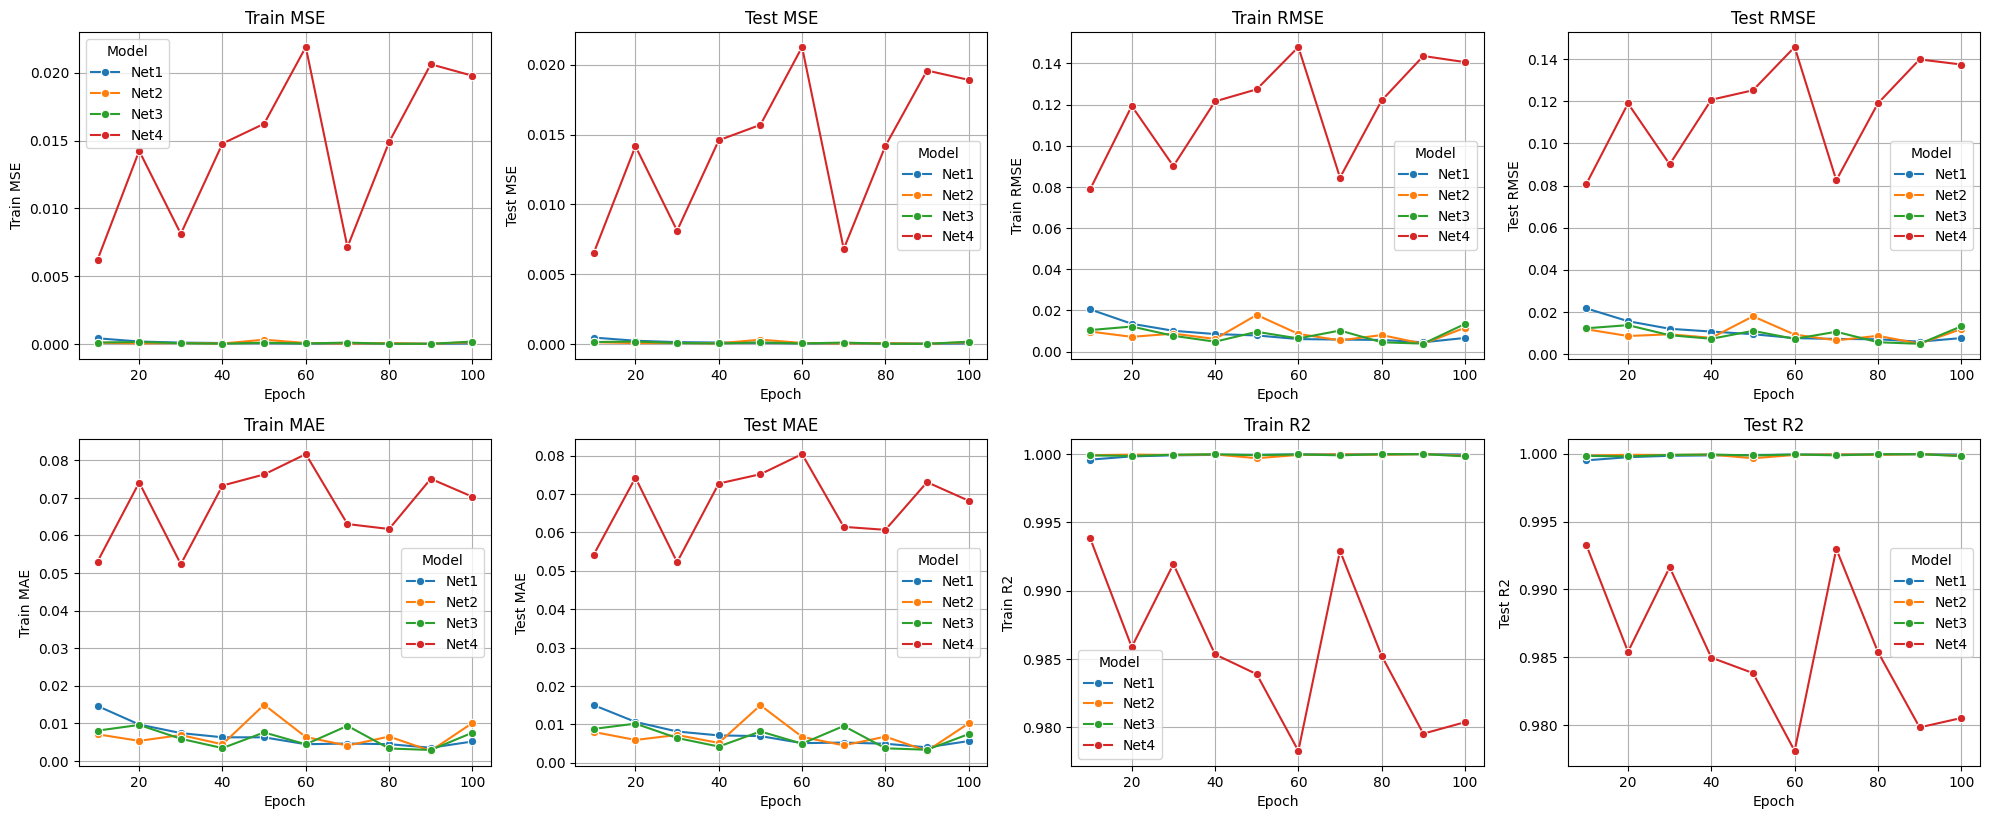

In [52]:
train_figures = {}
metrics_to_plot = ["Train MSE", "Test MSE", "Train RMSE", "Test RMSE", 
                   "Train MAE", "Test MAE", "Train R2", "Test R2"]

plt.figure(figsize=(20, 16))

for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(4, 4, i)
    sns.lineplot(data=nn_metrics_df, x="Epoch", y=metric, hue="Model", marker='o')
    plt.title(metric)
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.grid(True)

plt.tight_layout()
fig = plt.gcf()
train_figures["Train_Metrics_Nets"] = fig
plt.show()
plt.close()

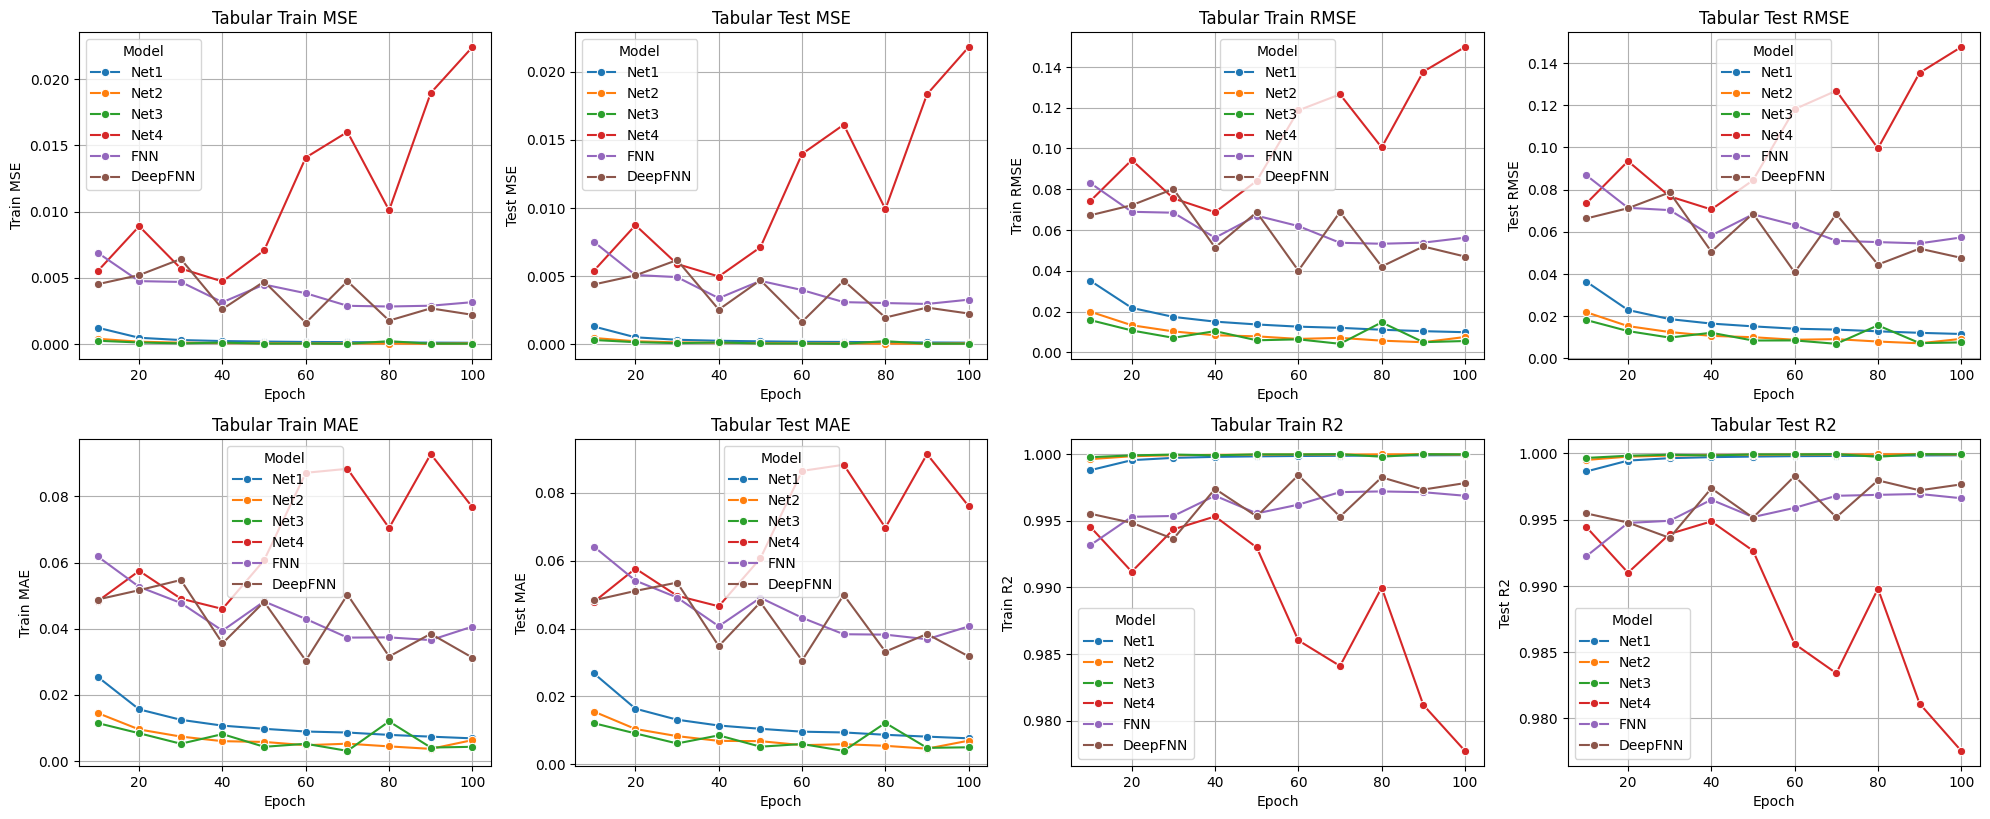

In [53]:
train_figures_tabular = {}

plt.figure(figsize=(20, 16))

for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(4, 4, i)
    sns.lineplot(data=nn_metrics_df_tabular, x="Epoch", y=metric, hue="Model", marker='o')
    plt.title("Tabular " + metric)
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.grid(True)

plt.tight_layout()
fig = plt.gcf()
train_figures_tabular["Train_Metrics_Tabular"] = fig
plt.show()
plt.close()

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X.values,         
    y.values,        
    test_size=0.2,
    shuffle=False
)

scaler_X = StandardScaler().fit(X_train)
X_train_scaled = scaler_X.transform(X_train)
X_test_scaled  = scaler_X.transform(X_test)

y_mean, y_std    = y_train.mean(), y_train.std()
y_train_norm     = (y_train - y_mean) / y_std
y_test_norm      = (y_test  - y_mean) / y_std

def create_sequence_data(X_arr, y_arr, seq_len=5):
    Xs, ys = [], []
    for i in range(len(X_arr) - seq_len):
        Xs.append(X_arr[i : i + seq_len])
        ys.append(y_arr[i + seq_len])
    return np.stack(Xs), np.stack(ys)

seq_len = 5
X_train_seq, y_train_seq = create_sequence_data(X_train_scaled, y_train_norm, seq_len)
X_test_seq,  y_test_seq  = create_sequence_data(X_test_scaled,  y_test_norm,  seq_len)

X_train_seq_tensor = torch.tensor(X_train_seq, dtype=torch.float32)  
y_train_seq_tensor = torch.tensor(y_train_seq, dtype=torch.float32).view(-1, 1)
X_test_seq_tensor  = torch.tensor(X_test_seq,  dtype=torch.float32)
y_test_seq_tensor  = torch.tensor(y_test_seq,  dtype=torch.float32).view(-1, 1)

train_loader_seq = DataLoader(
    TensorDataset(X_train_seq_tensor, y_train_seq_tensor),
    batch_size=64, shuffle=True
)
test_loader_seq  = DataLoader(
    TensorDataset(X_test_seq_tensor,  y_test_seq_tensor),
    batch_size=64, shuffle=False
)

In [23]:
in_channels = X_train_seq_tensor.shape[2]  

ts_nets = {
    "TCN":     TCN(in_channels, num_channels=[64,64]),
    "CNN1D":   CNN1D(in_channels, num_filters=32, num_layers=2, kernel_size=3, dropout=0.2),
    "GRUNet":  GRUNet(in_channels),
    "RNNNet":  RNNNet(in_channels),
    "CNNLSTM": CNNLSTM(in_channels),
    "BiLSTMNet":  BiLSTMNet(in_channels),
    "DeepLSTMNet":DeepLSTMNet(in_channels),
    "CNNBiLSTM":  CNNBiLSTM(in_channels),
    "GRUCNN":     GRUCNN(in_channels),
    "TCNLSTM":    TCNLSTM(in_channels),
    "Seq2SeqLSTM":Seq2SeqLSTM(in_channels),
}

In [25]:
results_ts = []
for name, net in ts_nets.items():
    results_ts += train_ts_model(
        name,
        net,
        train_loader_seq,       
        X_train_seq_tensor,     
        y_train_seq_tensor,     
        X_test_seq_tensor,      
        y_test_seq_tensor,      
        epochs=100,
        lr=1e-3
    )

nn_metrics_ts_df = pd.DataFrame(results_ts)

Training TCN: 100%|███████████████████████████████████████████████████████████████████████████████████████| 100/100 [08:20<00:00,  5.01s/it]



Model: TCN | Epoch: 100
Train: MSE: 0.0017, RMSE: 0.0417, MAE: 0.0254, R2: 0.9983
Test:  MSE: 0.0109, RMSE: 0.1043, MAE: 0.0370, R2: 0.9925


Training CNN1D: 100%|█████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.78it/s]



Model: CNN1D | Epoch: 100
Train: MSE: 0.0111, RMSE: 0.1055, MAE: 0.0667, R2: 0.9889
Test:  MSE: 0.0139, RMSE: 0.1179, MAE: 0.0816, R2: 0.9904


Training GRUNet: 100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.76it/s]



Model: GRUNet | Epoch: 100
Train: MSE: 0.0002, RMSE: 0.0145, MAE: 0.0104, R2: 0.9998
Test:  MSE: 0.0006, RMSE: 0.0252, MAE: 0.0144, R2: 0.9996


Training RNNNet: 100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.28it/s]



Model: RNNNet | Epoch: 100
Train: MSE: 0.0005, RMSE: 0.0220, MAE: 0.0164, R2: 0.9995
Test:  MSE: 0.0006, RMSE: 0.0251, MAE: 0.0176, R2: 0.9996


Training CNNLSTM: 100%|███████████████████████████████████████████████████████████████████████████████████| 100/100 [12:14<00:00,  7.35s/it]



Model: CNNLSTM | Epoch: 100
Train: MSE: 0.0031, RMSE: 0.0553, MAE: 0.0324, R2: 0.9969
Test:  MSE: 0.0039, RMSE: 0.0623, MAE: 0.0401, R2: 0.9973


Training BiLSTMNet: 100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [02:15<00:00,  1.35s/it]



Model: BiLSTMNet | Epoch: 100
Train: MSE: 0.0011, RMSE: 0.0336, MAE: 0.0216, R2: 0.9989
Test:  MSE: 0.0066, RMSE: 0.0809, MAE: 0.0332, R2: 0.9955


Training DeepLSTMNet: 100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [03:12<00:00,  1.92s/it]



Model: DeepLSTMNet | Epoch: 100
Train: MSE: 0.0018, RMSE: 0.0420, MAE: 0.0217, R2: 0.9982
Test:  MSE: 0.0021, RMSE: 0.0462, MAE: 0.0263, R2: 0.9985


Training CNNBiLSTM: 100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [02:41<00:00,  1.61s/it]



Model: CNNBiLSTM | Epoch: 100
Train: MSE: 0.0028, RMSE: 0.0524, MAE: 0.0315, R2: 0.9973
Test:  MSE: 0.0037, RMSE: 0.0610, MAE: 0.0362, R2: 0.9974


Training GRUCNN: 100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.32it/s]



Model: GRUCNN | Epoch: 100
Train: MSE: 0.0040, RMSE: 0.0635, MAE: 0.0358, R2: 0.9960
Test:  MSE: 0.0048, RMSE: 0.0694, MAE: 0.0462, R2: 0.9967


Training TCNLSTM: 100%|███████████████████████████████████████████████████████████████████████████████████| 100/100 [09:48<00:00,  5.89s/it]



Model: TCNLSTM | Epoch: 100
Train: MSE: 0.0014, RMSE: 0.0371, MAE: 0.0181, R2: 0.9986
Test:  MSE: 0.0015, RMSE: 0.0383, MAE: 0.0232, R2: 0.9990


Training Seq2SeqLSTM: 100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [01:27<00:00,  1.15it/s]


Model: Seq2SeqLSTM | Epoch: 100
Train: MSE: 0.0005, RMSE: 0.0227, MAE: 0.0159, R2: 0.9995
Test:  MSE: 0.0009, RMSE: 0.0302, MAE: 0.0189, R2: 0.9994


In [49]:
best_idx = nn_metrics_ts_df.groupby("Model")["Test R2"].idxmax()
best_results_ts = nn_metrics_ts_df.loc[best_idx].reset_index(drop=True)
best_results_ts = best_results_ts[cols]
best_results_ts

Model  Epoch  Train MSE  Test MSE  Train RMSE  Test RMSE  Train MAE  \
0     BiLSTMNet     50   0.001395  0.002668    0.037349   0.051655   0.023283   
1         CNN1D     60   0.008567  0.009747    0.092557   0.098727   0.046193   
2     CNNBiLSTM     60   0.003301  0.003441    0.057456   0.058657   0.031691   
3       CNNLSTM     90   0.002854  0.003143    0.053424   0.056064   0.028484   
4   DeepLSTMNet     80   0.002963  0.001893    0.054432   0.043514   0.021886   
5        GRUCNN     80   0.001522  0.004329    0.039017   0.065798   0.025321   
6        GRUNet    100   0.000209  0.000635    0.014470   0.025198   0.010393   
7        RNNNet     90   0.000390  0.000604    0.019758   0.024583   0.014085   
8   Seq2SeqLSTM    100   0.000516  0.000915    0.022714   0.030247   0.015857   
9           TCN     60   0.003898  0.005156    0.062435   0.071806   0.028817   
10      TCNLSTM     90   0.000333  0.000797    0.018235   0.028238   0.012278   

    Test MAE  Train R2   Test R2  
0   0.030096  0.998606  0.998158  
1   0.056764  0.991437  0.993271  
2   0.033845  0.996700  0.997625  
3   0.033028  0.997147  0.997830  
4   0.025851  0.997038  0.998693  
5   0.034592  0.998478  0.997011  
6   0.014355  0.999791  0.999562  
7   0.016997  0.999610  0.999583  
8   0.018933  0.999484  0.999368  
9   0.037764  0.996104  0.996440  
10  0.016854  0.999668  0.999450

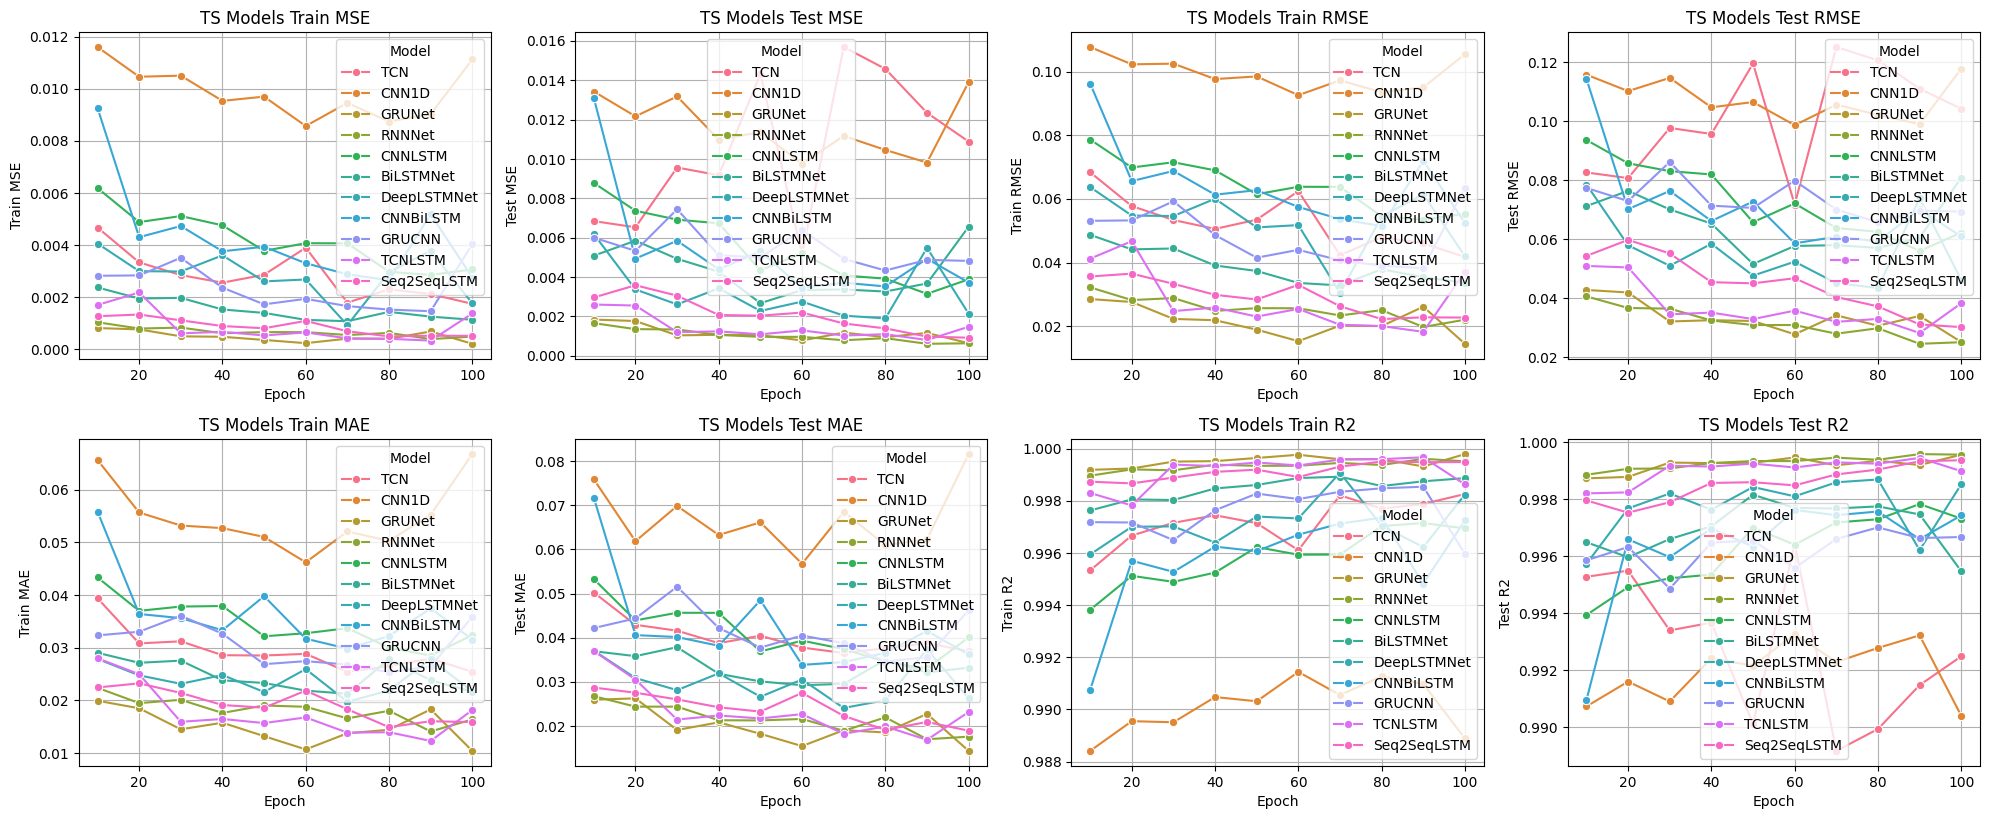

In [54]:
train_figures_ts = {}

models = ["TCN", "CNN1D", "GRUNet", "RNNNet", "CNNLSTM", "BiLSTMNet", "DeepLSTMNet", "CNNBiLSTM", "GRUCNN", "TCNLSTM", "Seq2SeqLSTM"]
df_models = nn_metrics_ts_df[nn_metrics_ts_df["Model"].isin(models)]

plt.figure(figsize=(20, 16))
for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(4, 4, i)
    sns.lineplot(data=df_models, x="Epoch", y=metric, hue="Model", marker='o')
    plt.title("TS Models " + metric)
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.grid(True)
plt.tight_layout()
fig = plt.gcf()
train_figures_ts["Train_Metrics_TS"] = fig
plt.show()
plt.close()

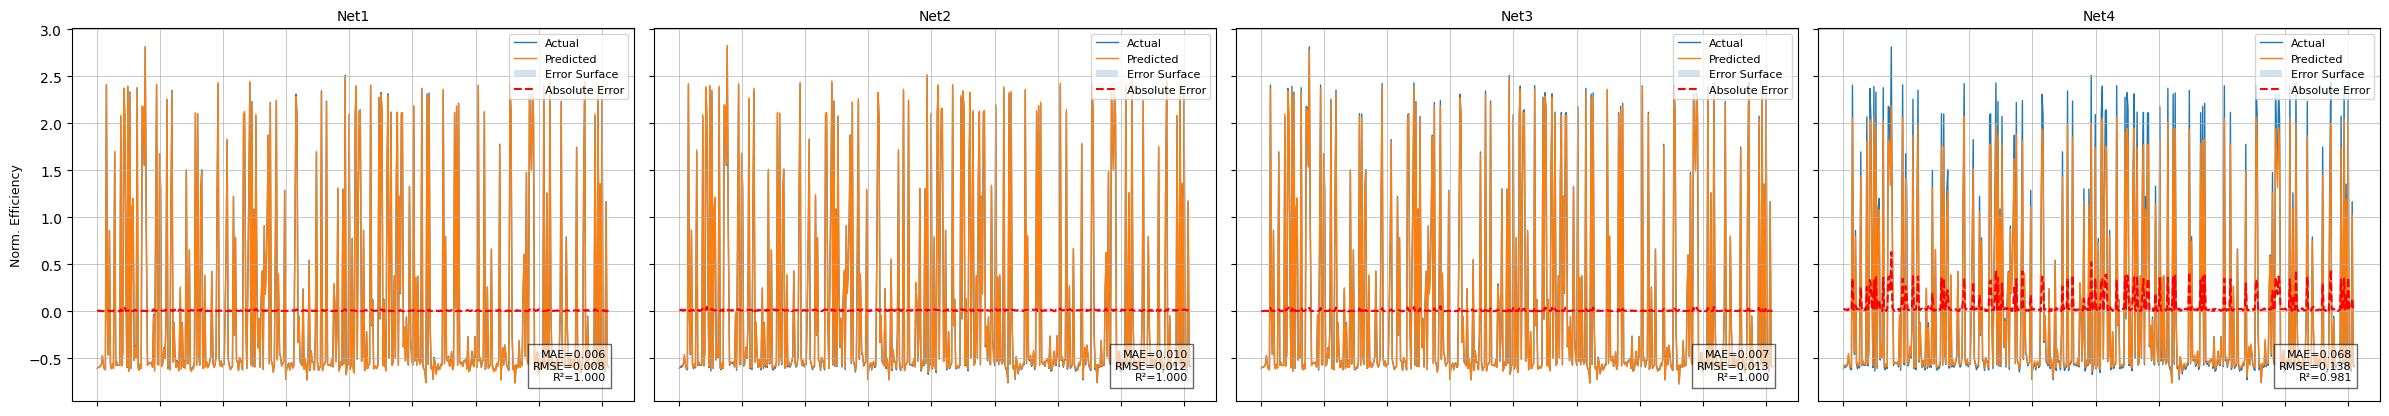

In [55]:
pred_figures_nets = {}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_models = len(nets)
ncols, nrows = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(24, 16),
                         sharex=True, sharey=True)
axes = axes.flatten()

desired = 2500   
max_pts = 500     

for i, (name, model) in enumerate(nets.items()):
    ax = axes[i]
    model = model.to(device).eval()

    with torch.no_grad():
        X_in = reshape_input(model, X_test_tensor.to(device))
        preds = model(X_in).cpu().numpy().flatten()
        trues = y_test_tensor.cpu().numpy().flatten()

    avail = trues.shape[0]
    n_samples = min(desired, avail)
    y_t = trues[-n_samples:]
    y_p = preds[-n_samples:]
    err = np.abs(y_t - y_p)

    idx = np.linspace(0, n_samples - 1,
                      min(n_samples, max_pts),
                      dtype=int)

    ax.plot(idx, y_t[idx],   label="Actual",    lw=1, zorder=1)
    ax.plot(idx, y_p[idx],   label="Predicted", lw=1, zorder=1)

    ax.fill_between(idx, y_t[idx], y_p[idx],
                    alpha=0.2, label="Error Surface", zorder=0)
    
    ax.plot(idx, err[idx],
            '--', lw=1.5, color='red',
            label="Absolute Error", zorder=3)

    m = (nn_metrics_df
         .query("Model == @name")
         .sort_values("Epoch")
         .iloc[-1])
    stats = (
        f"MAE={m['Test MAE']:.3f}\n"
        f"RMSE={m['Test RMSE']:.3f}\n"
        f"R²={m['Test R2']:.3f}"
    )
    ax.text(.95, .05, stats,
            transform=ax.transAxes,
            ha='right', va='bottom',
            fontsize=8,
            bbox=dict(facecolor='white', alpha=0.6))

    ax.set_title(name, fontsize=10)
    ax.grid(True, linewidth=0.5)

    if i % ncols == 0:
        ax.set_ylabel("Norm. Efficiency", fontsize=9)
    if i // ncols == nrows - 1:
        ax.set_xlabel("Sample Index", fontsize=9)

    ax.legend(fontsize=8, loc="upper right")

for j in range(n_models, nrows * ncols):
    fig.delaxes(axes[j])

plt.tight_layout()
pred_figures_nets["Prediction_Nets"] = fig
plt.show()
plt.close()

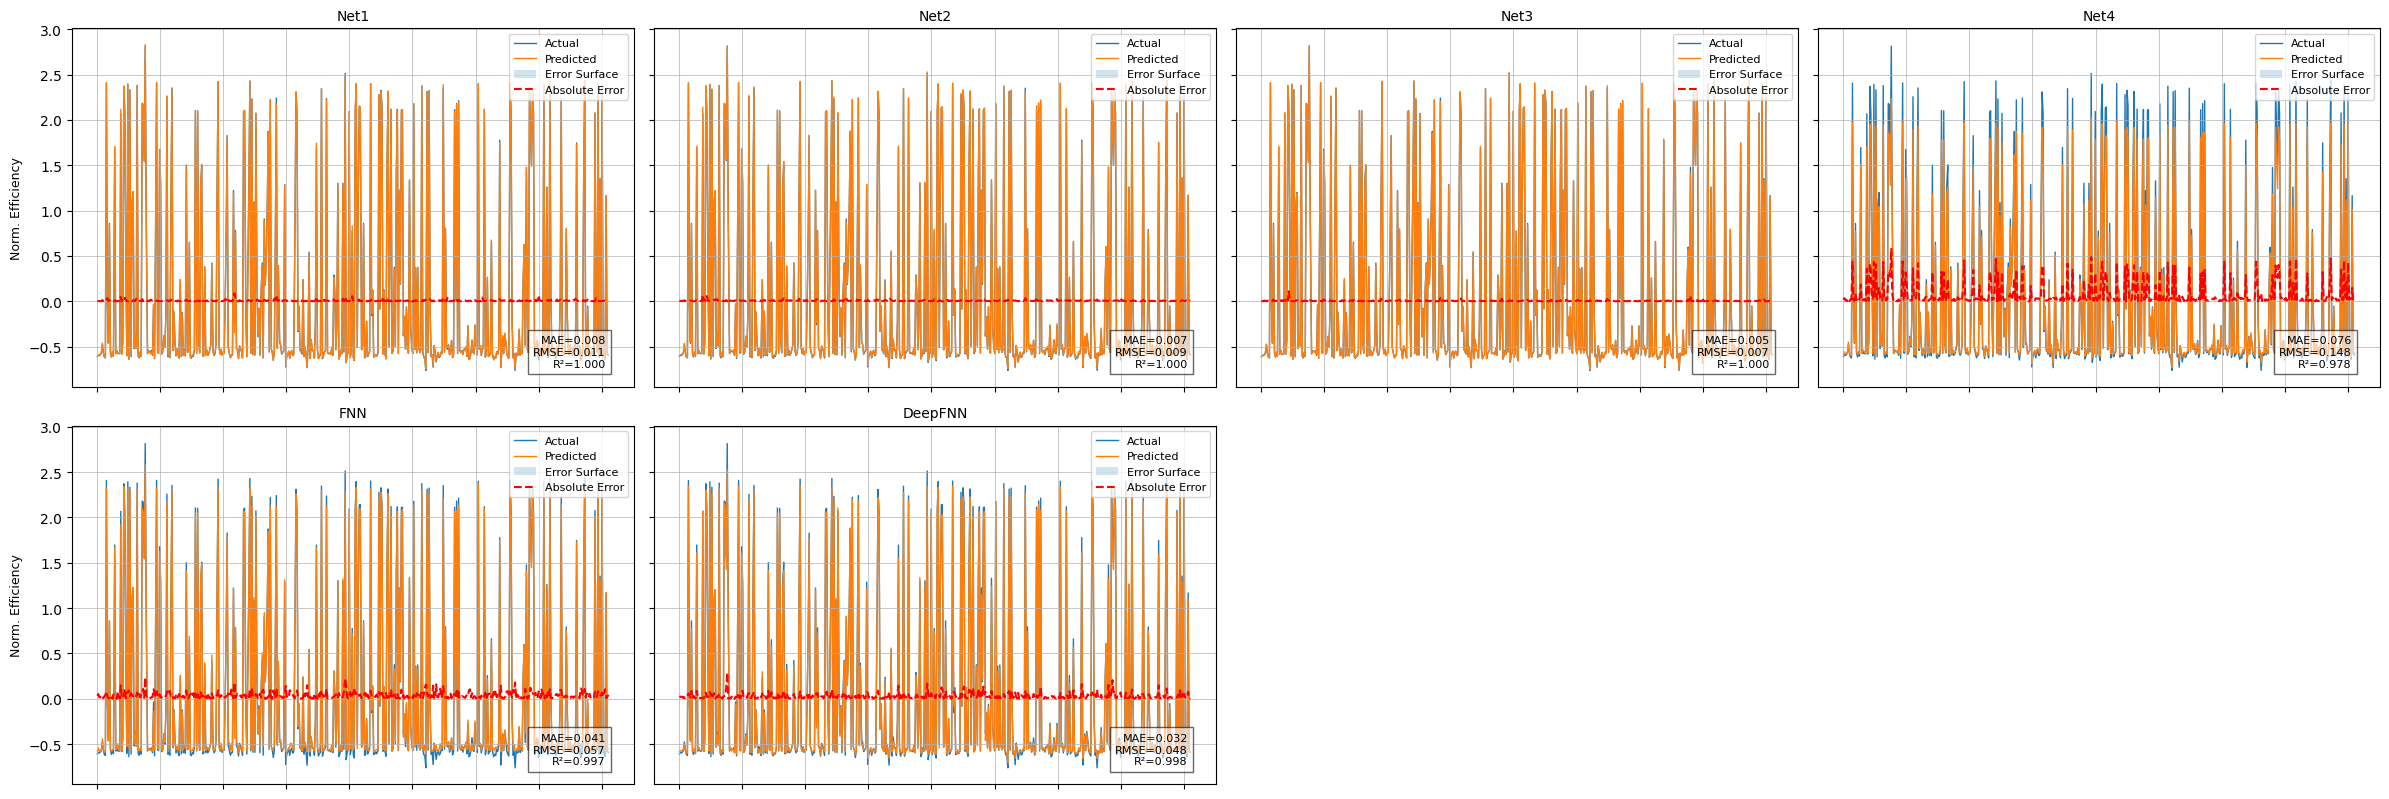

In [56]:
pred_figures_nets_tab = {}

n_models = len(nets_tabular)
ncols, nrows = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(24, 16),
                         sharex=True, sharey=True)
axes = axes.flatten()

desired = 2500   
max_pts = 500     

for i, (name, model) in enumerate(nets_tabular.items()):
    ax = axes[i]
    model = model.to(device).eval()

    with torch.no_grad():
        X_in = reshape_input(model, X_test_tensor.to(device))
        preds = model(X_in).cpu().numpy().flatten()
        trues = y_test_tensor.cpu().numpy().flatten()

    avail = trues.shape[0]
    n_samples = min(desired, avail)
    y_t = trues[-n_samples:]
    y_p = preds[-n_samples:]
    err = np.abs(y_t - y_p)

    idx = np.linspace(0, n_samples - 1,
                      min(n_samples, max_pts),
                      dtype=int)

    ax.plot(idx, y_t[idx],   label="Actual",    lw=1, zorder=1)
    ax.plot(idx, y_p[idx],   label="Predicted", lw=1, zorder=1)

    ax.fill_between(idx, y_t[idx], y_p[idx],
                    alpha=0.2, label="Error Surface", zorder=0)
    
    ax.plot(idx, err[idx],
            '--', lw=1.5, color='red',
            label="Absolute Error", zorder=3)

    m = (nn_metrics_df_tabular
         .query("Model == @name")
         .sort_values("Epoch")
         .iloc[-1])
    stats = (
        f"MAE={m['Test MAE']:.3f}\n"
        f"RMSE={m['Test RMSE']:.3f}\n"
        f"R²={m['Test R2']:.3f}"
    )
    ax.text(.95, .05, stats,
            transform=ax.transAxes,
            ha='right', va='bottom',
            fontsize=8,
            bbox=dict(facecolor='white', alpha=0.6))

    ax.set_title(name, fontsize=10)
    ax.grid(True, linewidth=0.5)

    if i % ncols == 0:
        ax.set_ylabel("Norm. Efficiency", fontsize=9)
    if i // ncols == nrows - 1:
        ax.set_xlabel("Sample Index", fontsize=9)

    ax.legend(fontsize=8, loc="upper right")

for j in range(n_models, nrows * ncols):
    fig.delaxes(axes[j])

plt.tight_layout()
pred_figures_nets_tab["Prediction_Nets_Tab"] = fig
plt.show()
plt.close()

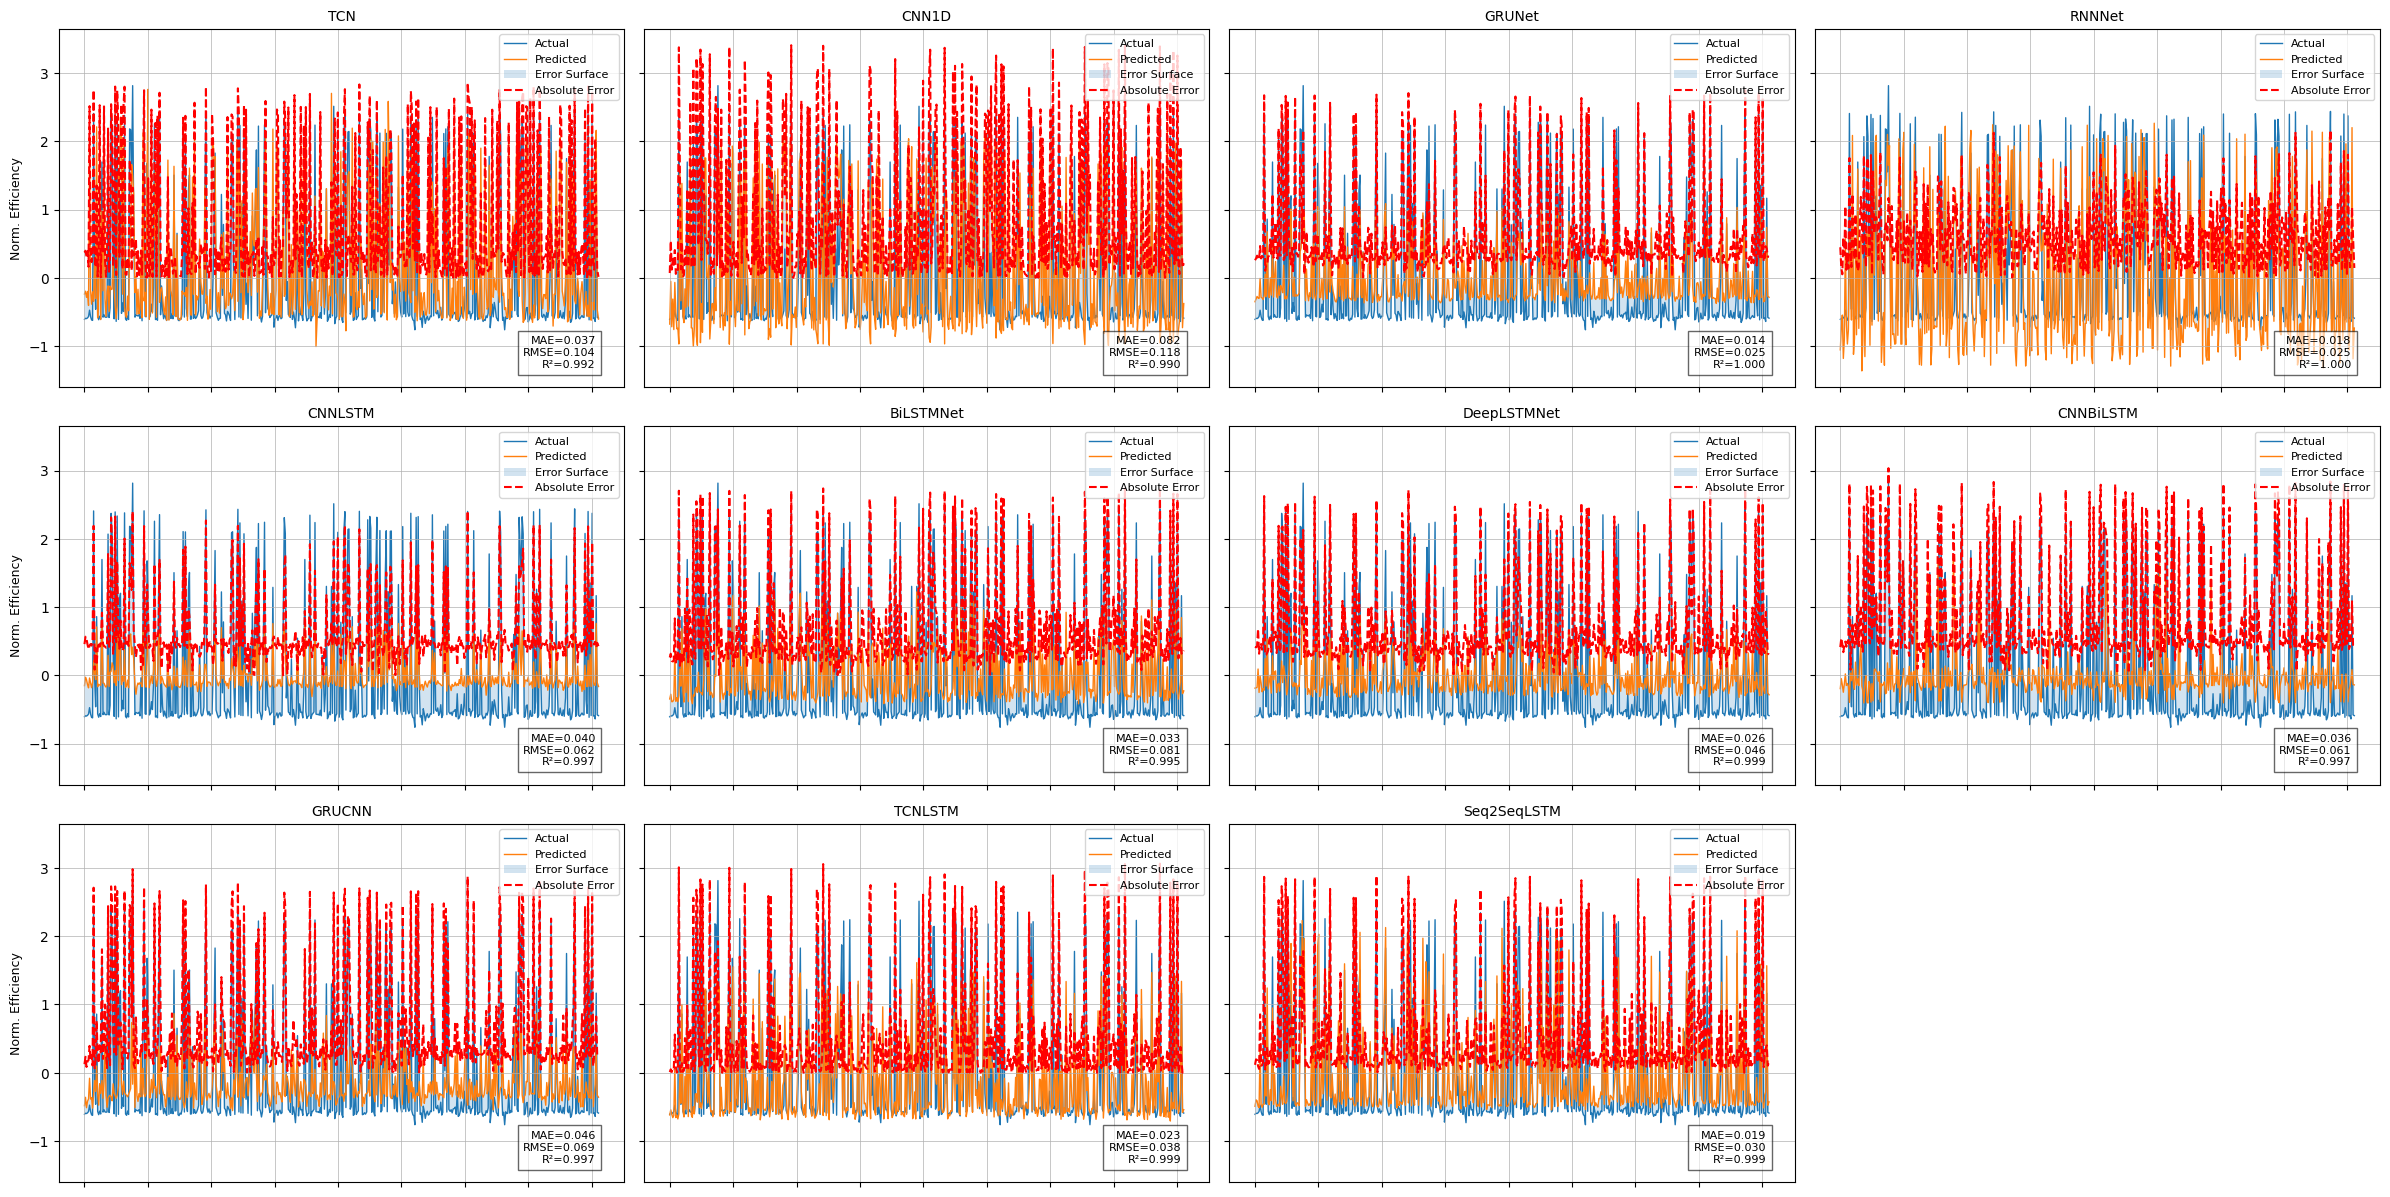

In [57]:
pred_figures_nets_ts = {}

n_models = len(ts_nets)
ncols, nrows = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(24, 16),
                         sharex=True, sharey=True)
axes = axes.flatten()

desired = 2500   
max_pts = 500     

for i, (name, model) in enumerate(ts_nets.items()):
    ax = axes[i]
    model = model.to(device).eval()

    with torch.no_grad():
        X_in = reshape_input(model, X_test_tensor.to(device))
        preds = model(X_in).cpu().numpy().flatten()
        trues = y_test_tensor.cpu().numpy().flatten()

    avail = trues.shape[0]
    n_samples = min(desired, avail)
    y_t = trues[-n_samples:]
    y_p = preds[-n_samples:]
    err = np.abs(y_t - y_p)

    idx = np.linspace(0, n_samples - 1,
                      min(n_samples, max_pts),
                      dtype=int)

    ax.plot(idx, y_t[idx],   label="Actual",    lw=1, zorder=1)
    ax.plot(idx, y_p[idx],   label="Predicted", lw=1, zorder=1)

    ax.fill_between(idx, y_t[idx], y_p[idx],
                    alpha=0.2, label="Error Surface", zorder=0)
    
    ax.plot(idx, err[idx],
            '--', lw=1.5, color='red',
            label="Absolute Error", zorder=3)

    m = (nn_metrics_ts_df
         .query("Model == @name")
         .sort_values("Epoch")
         .iloc[-1])
    stats = (
        f"MAE={m['Test MAE']:.3f}\n"
        f"RMSE={m['Test RMSE']:.3f}\n"
        f"R²={m['Test R2']:.3f}"
    )
    ax.text(.95, .05, stats,
            transform=ax.transAxes,
            ha='right', va='bottom',
            fontsize=8,
            bbox=dict(facecolor='white', alpha=0.6))

    ax.set_title(name, fontsize=10)
    ax.grid(True, linewidth=0.5)

    if i % ncols == 0:
        ax.set_ylabel("Norm. Efficiency", fontsize=9)
    if i // ncols == nrows - 1:
        ax.set_xlabel("Sample Index", fontsize=9)

    ax.legend(fontsize=8, loc="upper right")

for j in range(n_models, nrows * ncols):
    fig.delaxes(axes[j])

plt.tight_layout()
pred_figures_nets_ts["Prediction_Nets_TS"] = fig
plt.show()
plt.close()

In [59]:
for name, model in nets.items():
    save_experiment(
        station="Global",
        model_name=name,
        net=model,
        metrics_df=nn_metrics_df[nn_metrics_df["Model"] == name],
        train_figs={"Train_Metrics": train_figures["Train_Metrics_Nets"]},
        pred_figs={"Predictions": pred_figures_nets["Prediction_Nets"]},
        base_dir=Path("..")
    )

In [60]:
for name, model in nets_tabular.items():
    save_experiment(
        station="Global",
        model_name=name,
        net=model,
        metrics_df=nn_metrics_df_tabular[nn_metrics_df_tabular["Model"] == name],
        train_figs={"Train_Metrics": train_figures_tabular["Train_Metrics_Tabular"]},
        pred_figs={"Predictions": pred_figures_nets_tab["Prediction_Nets_Tab"]},
        base_dir=Path("..")
    )

In [61]:
for name, model in ts_nets.items():
    save_experiment(
        station="Global",
        model_name=name,
        net=model,
        metrics_df=nn_metrics_ts_df[nn_metrics_ts_df["Model"] == name],
        train_figs={"Train_Metrics": train_figures_ts["Train_Metrics_TS"]},
        pred_figs={"Predictions": pred_figures_nets_ts["Prediction_Nets_TS"]},
        base_dir=Path("..")
    )